---
# Precomputed Bounding Surface Implementation
---
> Copyright ©2019 Arduino Computational Geomechanics Group and Justin Bonus.  All rights reserved. No use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these materials should contact the author.
---

This notebook presents the process of calculating all possible discrete solutions to a differential equation within a natural boundary, storing them in an accesible format. In effect, it 'solves' the constitutive relationship in its entirety, thereby completely removing the need to ever recalculate solutions for the constitutive model.

This idea will be examined in the context of a specific constitutive model, *Borjas & Amies 1994*, due to its simplicity yet flexibility, but could be applied to varous other models.

Use of this notebook requires access to other notebook (which should be kept in the same file directory, i.e. folder):

 - `Utilities.ipynb` - Basic functions, primarily for vector manipulation
 - `Precomputed.ipynb` - Functions specific to the precomputed model
 - `Visuals.ipynb` - Figures to be used
 - `Animations.ipynb` - Code for animation various visuals
 - `Arduino.ipynb` - Contains the drivers and radial maps for the model
 - `Precomputed Bounding Surface Solution Matrices.ipynb` - Walkthrough on construction and reasoning behind solution matrices
 - `CESG508 Bounding Surface.ipynb` - Describes the behavior of the bounding surface model

A number of common libraries must be imported to use/edit the entire notebook in the .ipynb format. 
 - ```numpy``` - For basic math and array manipulation
 - ```collections.namedtuple``` - For variable structures
 - ```scikit``` - For some geometry
 - ```matplotlib``` - For data visualization
 - ```mpl_toolkits``` - For 3D plotting
 - ```ffmpeg``` - For animation embedment

For those using the notebook in .html or .pdf format it is unneccesary to install any packages.

It is generally a good idea to restart the kernel and run all cells sequentially to make sure the code runs correctly.

In [108]:
# For basic math, arrays, and structures
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import minimize_scalar

import numpy as np

from collections import namedtuple
from IPython.display import HTML
from IPython.display import display

from skimage.draw import line
from skimage.draw import circle_perimeter

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
# Import various functions
%run ./Utilities.ipynb
%run ./Visuals.ipynb
%run ./Animations.ipynb
%run ./Misc.ipynb
%run ./Precomputed.ipynb

It's fairly difficult to visualize the model just by following the derivation, especially if this is your first time working with it. Run the following cell to output the interactive model. Use your mouse to rotate the scene.

<IPython.core.display.Javascript object>


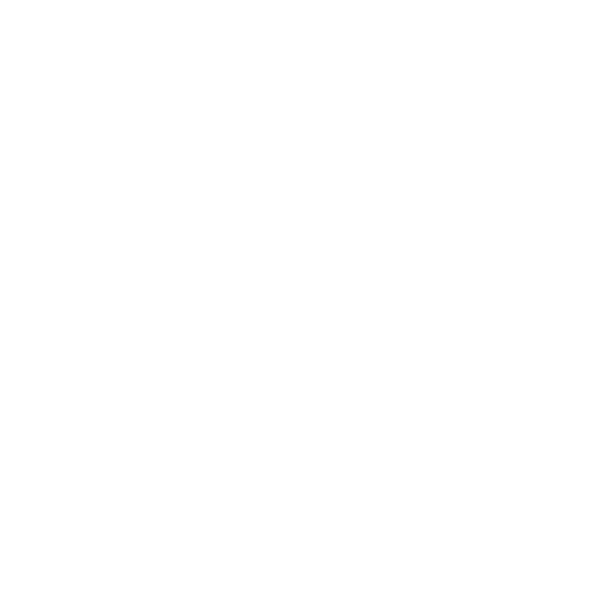

In [69]:
%matplotlib notebook
%matplotlib notebook
borjasInteractive()

In [70]:
plt.close()

---
# Precomputation

As it stands, a differential equation is being solved via Newton-Rhapson iterations for every time step in order to produce a deviatoric stress increment. This method slows as the model becomes increasingly plastic, and oftentimes identical solutions are recomputed.

Modern advances in cloud computation, parallel computation, and general data storage have allowed for completely removing real-time solutions from constitutive models. Instead, accessing precomputed matrices containing all possible solutions replaces the computationally expensive solver method with a series of matrix calls.

Traditional perspectives might suggest that matrices containing all solutions are:
 * Too large to store
 * Too large to compute
 
However, by utilizing the natural boundary of the equations (i.e. the stress bounding surface for Borjas & Amies 1994) and various instances of solution symetry and redundancy, the matrices can be made relatively compact and quick to compute.

A total of **three** precomputed matrices will be assembled:
 * $\kappa$ Matrix
 * $H'$ Matrix
 * $\psi$ Matrix

Matrices will be created in a cartesian representation of the $\Pi$-plane. This is for ease of construction and access. A polar coordinate system is a more compact alternative as it does not include any cells outside of the bounding surface, but is slightly less intuitive to construct and access.


---
## Spaces

Making solution matrices viable for 3D constitutive models is heavily dependent on reducing dimensionality. Every added dimension to a stress (or strain) space increases the dimension of our solution matrices and thereby its digital footprint. 

Borjas & Amies 1994 is a reasonably simple model defined by a Von-mises cylinder bounding surface and $\kappa$ contours. Here we demonstrate that a Von-mises cylinder is effectively 2D for $\kappa$ values as they do not vary along the hydrostatic axis. We also argue that rotational symetry exists within the cylinder around the hydrostatic axis for the unloading stress and around the $\kappa$ contour centers for the active stress (but we will not use this specific symmetry). To save ourselves from getting to confused, we will formally describe the spaces we will use--and why.

Different spaces will be used within this constitutive model in order to reduce computational time and to keep calculations clean.

* Principal $\pmb{\sigma}$ space - 3D space with axis representing principal stresses. Is only used for stress-strain input and output, no calculations are performed within it past seperating deviatoric and volumetric components.
* $O\Pi$ - 2D and located on the deviatoric plane, with it's origin at the hydrostatic axis. Used for 2D calculations on the deviatoric plane.
* $A\Pi$ - 2D and located on the deviatoric plane, but the origin is at the intersection of lines tangent to the North and West edge of the bounding surface. Directly compatible with typical array access and thereby used for accessing the solution matrices. The origin location makes it difficult to use for calculations, but some Python libraries were designed for $A\Pi$ array space.

The $O\Pi$ and $A\Pi$ spaces can be used in either float or integer form. Float form maintains all the information from 3D principal stress space but can be relatively slow to compute on. Rotations and recentering will be done here. Integer form loses information but makes calculations quicker. It will mostly be used for accessing solution matrices, as they require integer inputs. 

<IPython.core.display.Javascript object>


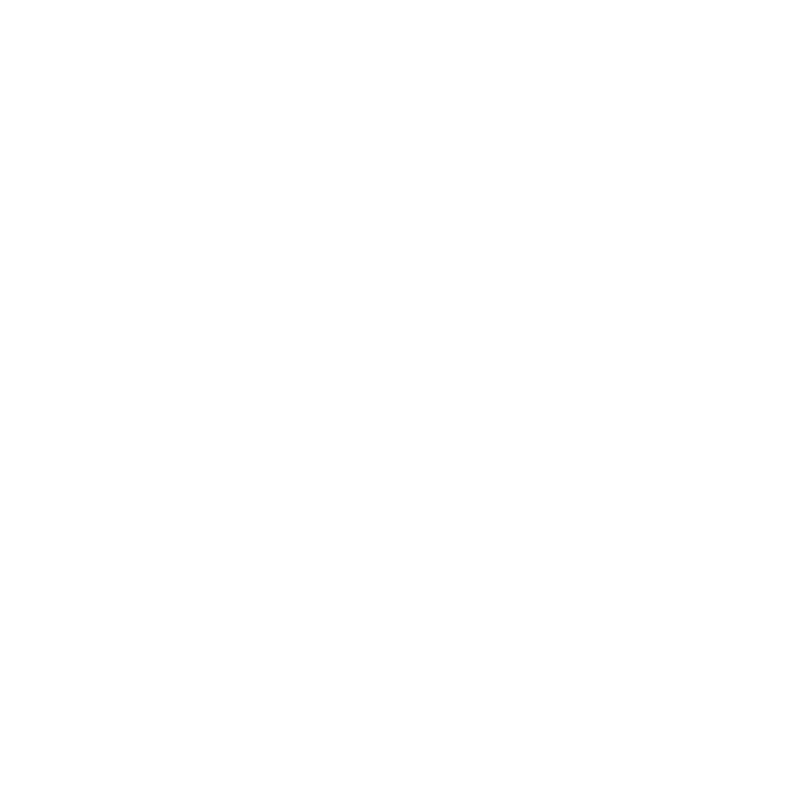

In [71]:
spaceVis()

---
On a personal computer it is recommended to not exceed a resolution of ~101. Many computers can handle higher resolution matrices, but Jupyter notebook throttles CPU usage (e.g. limits to one core) and can crash when trying to load large matrices (especially the $\psi$ matrix) into the RAM.

In [72]:
# Clean RAM
kappaM, hardeningM, psiM = None, None, None

---
# Parameters

Two sets of parameters are needed for the use of a precomputed constitutive model. The first is a typical material parameters that the traditional version of the model needs, the second is parameters for a solution matrix. Solution matrix parameters are the neccesary information the model needs to properly access and use a solution matrix, in this instance it will be the $x$ and $y$ resolution and the minimum and maximum $\kappa$ values contained. For other types of matrices it may be neccesary to have parameters that describe the grid distribution and other properties of the solution matrix.

In [73]:
#============================== MATRIX SETTINGS ==============================
res_x = 51 # Best to remain within [51, 251] unless your system has a lot of RAM
res_y = res_x # Symmetry of x and y resolutions
minKappa = 1e-5
maxKappa = 1e6
#=============================================================================

In [74]:
#============== STATIC PARAMETERS ==============
E = 20 #Elastic Modulus  MPa
v= 0.49 #Poissons ratio, less than 0.5 to allow compresibility
Su = 0.061 #Yield stress in 1-D tension test MPa

G = E/(2*(1+v)) #Shear modulus
K = E/(3*(1-2*v)) #Bulk modulus
RR = Su*(8/3)**0.5 #R

mm = 1.0 #kinematic hardening parameter
hh = round(G,4) #kinematic hardening parameter, rounded for cleanliness
Kmod = 0 #Isotropic Hardening
beta = 0.5 #Midpoint integration
#===============================================

# Creating the $\kappa$ Matrix

`Precomputed Bounding Surface Constitutive Model - Solution Matrices.ipynb` details the specifics of the theory behind solution matrices and how they were constructed for this model, but here we will just briefly review what is happening -- and why.

Remember that a solution matrix is a way to discretize non-linear equations. In this instance we are concerned with the following two:

$$\pmb{\hat{\sigma}}' = \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') $$

$$ \left\lVert \pmb{\hat{\sigma}}' \right\rVert = \left\lVert \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') \right\rVert = R $$

This is a reasonably simple example of non-linear equations (i.e. well behaved, can reach convergences quickly with very few issues). However, solving it during run-time in the traditional implementation of this model is still the bottleneck for computational speed. By discretizing the set of equations on a deviatoric stress space grid and collapsing certain basic symmetries it is possible to have a compact solution matrix (~1 - 100 MB) with a fineness that avoids notable errors ( < 5% differences in stress components). 

This process has been completed in the previously mentioned Jupyter Notebook. A new function, `kappaLayer()`, will perform this 1D calculation and then appropiately distributes these $\kappa$ values throughout the layer (representing the $A\Pi$-Plane) for a specific unloading stress.

By calling `kappaLayer()` sequentially (or in parallel) as we vary the position of the unloading stress from the center of the $\Pi$-plane to the top edge of the bounding surface, we can create all the layers need to fully define the $\kappa$ matrix. A new function, `kappaMatrix()` will perform this action and output the assembled matrix.

Call `kappaMatrix()` below to create the $\kappa$ matrix, save it to directory, and remove it from RAM.

In [75]:
#===============================================================================================
kappaM = kappaMatrix(res_x, res_y, minKappa, maxKappa)
#===============================================================================================
# Write array to *.txt file on disk (HDD, SSD)
dr = '../Sets/'
fn = dr + 'kappaMatrix_' + str(res_x) + '_' + str(res_y) + '.txt'
with open(fn, 'w') as outfile:
    # Text header for readibility
    outfile.write('# Array shape: {0}\n'.format(kappaM.shape))
    # Iterates through a ndimensional array producing slices along
    # the last axis. This is equivalent to data[i,:,:]
    for data_slice in kappaM:
        # Left-justified columns 7 characters in width, 8 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.8f')

        # Layer breaks using '#', won't be read by loadtxt()
        outfile.write('# New slice\n')

# Remove array from RAM
kappaM = None 
print('kappaMatrix.txt saved to disk and removed from RAM.')
#===============================================================================================

Layer: 25 of  25
Kappa Matrix Shape: (51, 51, 26)
kappaMatrix.txt saved to disk and removed from RAM.


Load $\kappa$ matrix into RAM. Whatever the resolution settings is set to will determine which $\kappa$ matrix file is loaded. Matrices above 201 resolution may take a few minutes to load into the RAM on weaker computers.

In [76]:
def loadKappa(res_x, res_y):
    #===============================================================================================
    # Read the array from disk
    dr = '../Sets/'
    fn = dr + 'kappaMatrix_' + str(res_x) + '_' + str(res_y) + '.txt'
    kappaMatrix = np.loadtxt(fn).reshape((res_y,res_x,int(np.floor(res_y/2))+1)) # Returns 3D array
    print('Loaded array kappaMatrix into RAM, shape:', kappaMatrix.shape)
    #===============================================================================================
    return kappaMatrix

In [77]:
def resVals(shape):
    res_x = shape[1]
    res_y = shape[0]
    cen_x = shape[2] - 1
    cen_y = cen_x
    return res_x, res_y, cen_x, cen_y

In [78]:
kappaM = loadKappa(res_x,res_y)

Loaded array kappaMatrix into RAM, shape: (51, 51, 26)


Visualize a layer of the matrix in 2D and 3D.

<IPython.core.display.Javascript object>


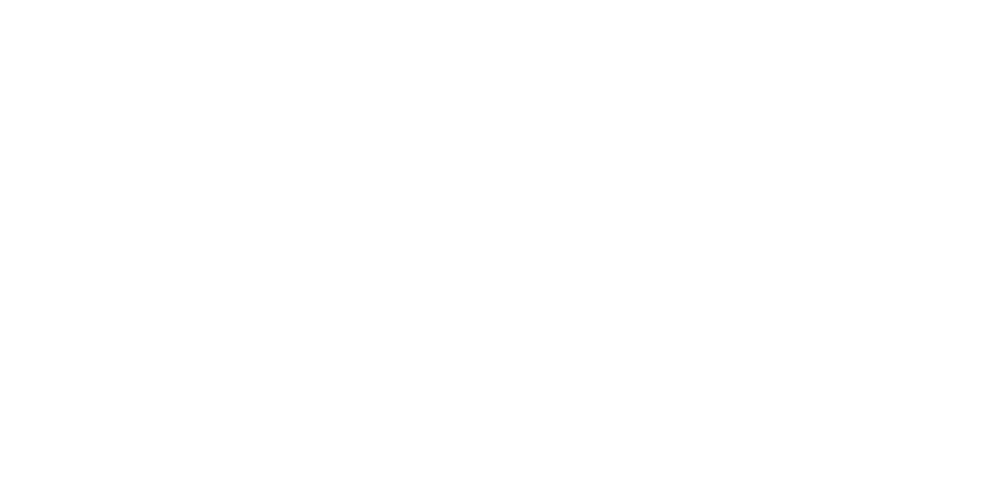

In [79]:
kappaLayer_plot()

<IPython.core.display.Javascript object>


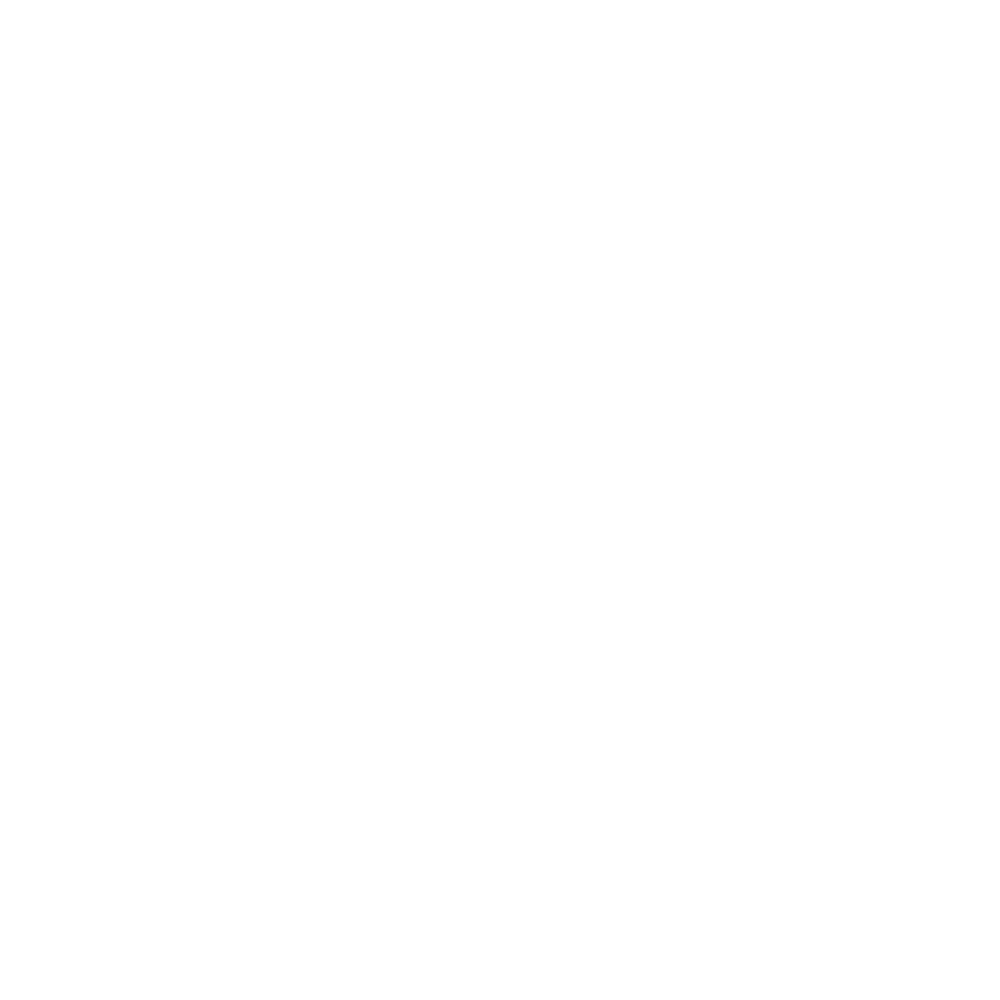

In [80]:
kappaLayer_surf()

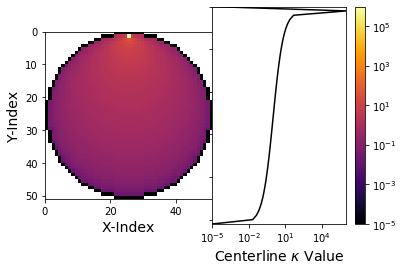

In [81]:
kappaMatrix_animation(kappaM)

---
# Map to Access Space

* Discretize
* Collapse Symmetries

Starting in a 9D or 6D Cauchy stress space we must take our stress state and convert it into 3D principla stress space. Next we bring it into the deviatoric plane (still represented with 3D components). Then a Stress-to-Index mapping must occur so as to discretize the state appropiately. Rotational symmetry is now collapsed by means of rotating the state so it is north-aligned. Access space has succesfully been mapped into.


## Stress-to-Index Mapper

To access the precomputed matrices for a given stress state we must first map the stress position to index position. In this noteboook it is demonstrated for deviatoric 3D principal stresses. 

$ [\pmb{\sigma}_1,\pmb{\sigma}_2,\pmb{\sigma}_3]^T \rightarrow [i, j]^T$

This could also be done for a 9D or 6D representation of stress, but would lack a decent visualization method.

In other words, we will map the stress viewed from the $\Pi$-plane to the appropiate indexes of the precomputed matrices, which were constructed to be visually consistent with the $\Pi$-plane.

The stress-to-index mapping function must be kept lightweight as it will be accessed for every time step. `stressToIndex()` can be found in `Precomputed.ipynb`.

Since $\Pi$-plane index-space is 2D, some computations can be performed within it more efficiently than in 3D normal stress space. Float index-space will maintain the same level of precision as 3D space to make this possible.


## Angle-Finder and Rotator

The precomputed matrices were significantly reduced in size due to rotational symetry of stresses viewed from the $\Pi$-plane. To properly access the matrices we will need to take our raw stress state and rotate it into the proper orientation.

 * Gather the angle, $\theta$ between the unloading stress point and a 'North' pointing vector
 * Rotate the unloading stress and current stress backwards by $\theta$, this ensures the unloading stress is on the centerline and that the current stress has retained it's relative orientation

We'll need to keep our angle-finding and rotation methods lightweight because they will be used every timestep. There is also the choice of performing these operations in normal stress space or index space. Normal stress space is more computationally expensive to perform calculations in, as it features three dimensions and float values. Index space is computationally cheap due to its two dimensions and integer values but is prone to error when using low-resolution matrices. For this exercise the operation will be done in normal stress space.

`indexRotator()`, `indexAngle()`, and `normalAngle()` can be found in `Precomputed.ipynb`.

---
Dimensionality reduction isn't exactly intuitive, especially when its phrased in terms of rotations.
Let's look at an animation of what is really happening. The start of the animation represents some initial, random stress state. It then rotates the unloading stress onto the North section of the centerline. Finally it rotates the active stress onto the South section of the centerline (this step isn't neccesary, but it further reduces dimensionality). 

Notice that the active stress stays at the same $\kappa$ value throughout the rotations.

In [82]:
# ======== Visualize North-South Alignment Rotator ========

Su = 0.061 # Undrained shear strength MPa, controls bounding surface
R = Su*(8/3)**0.5 # Radius of bounding surface

rand = np.random.random((6,)) # Randomize stress state
sign = (2*np.random.randint(0,2,size=(6,))-1).reshape(6,) # Randomize stress polarity
rand = rand * sign
Stress0 = dev(np.array([[R*rand[0]],[R*rand[1]],[R*rand[2]]])) # Unloading stress
CurStress = dev(np.array([[R*rand[3]],[R*rand[4]],[R*rand[5]]])) # Current stress

# Prevents stress exiting bounding surface
if normS(Stress0) >= R:
    Stress0 = 0.99 * Stress0 * (R/normS(Stress0))
if normS(CurStress) >= R:
    normS(CurStress)/R
    CurStress = 0.99 * CurStress * (R/normS(CurStress))

# Create rotating stress-state and animation
time, Stress0, stress = rotateDemo(Stress0, CurStress)
ani = animateDeviatoricSurface(time, Stress0, stress, Su)
ani

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

---
# Access Solution Matrix

## Search Coordinates

We now have a way to access the solution matrix for any given stress state, but one issue remains: We don't know what our next stress state is. 

Iteration will need to be introduced for any step that is driven by a strain-increment (but not for any stress-increment driven step, discussed later). This iteration will seek to determine a new stress state that when taken with the current stress state minimizes some function that ensures the validity of the model. Here we will use the following minimization function:


The problem lies in the fact that for our (N x M x O) solution matrix we are only confidenent in a our next stress states position in one of the dimensions, which is determined from the unloading stress that depends only on our current stress state and the deviatoric strain increments direction. To find the remaining two dimensions of our solution we will have to iterate through our known 2D layer until a coordinate is found containing a $\kappa$ that minimizes our objective function.

Going through every coordinate on a 2D array and performing simple arithematic is easy enough but but gets out of hand quickly. For a 101 x 101 layer we will have 10101 coordinates to evaluate, a task that is undoubtedly slower than traditional iteration methods. Four measures must be taken to make this viable:

* 1. Consider only coordinates holding viable solutions
* 2. Define a tolerance to allow early-exits
* 3. Refine the order in which coordinates are evaluated
* 4. Potentially parallelize the process

Iterating through discrete lists is a fundamentally brutish task as convergence can not be achieved for what is essentially a discontinous function. In a scenario where we do not have any prior knowledge on the validity of each element in the list, nor on the order of their likelihood, we are forced to evaluate every single value. In this case we are lucky, as constitutive models obey rules of our construction, rules which influence how we may view our discrete list of possible solutions.

Consider that the direction of $\Delta \pmb{\epsilon}'$ always equals the direction of $\Delta \pmb{\sigma}'$. We know the direction of our strain increment in the deviatoric plane, that means the direction of our stress increment on the deviatoric plane is also known to be the same. Since the solution matrix was constructed to resemble deviatoric stress space we therefore understand that the coordinate holding our solution will be in the direction of our stress increment if we start from the coordinate representing our curret stress position.

So what does this mean? Essentially, by recognizing the laws of our model we have been able to identify with complete certainty a geometric regime in our solution matrix that must contain the most appropiate solution. For this implementation the geometric regime is a line of coordinates that start at our current stress position and extends in the direction of our strain increment. A 2D search space has collapsed into a 1D space. This is significant as it takes what may have been a search requiring 10101 evaluations and has capped it to a maximum of 101 evaluations. In practice far fewer will be required to find the appropiate solution.

In [83]:
#!pip install scikit-image
from skimage.draw import line

midpoint: 50
Angle: 150.0


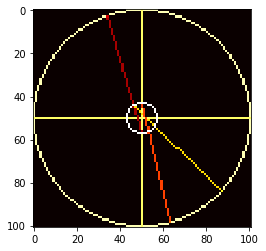

In [84]:
psiSearch_plot()

In [85]:
%run ./Precomputed.ipynb

Each coordinate in the solution matrix will have a residual value relative to our current stress state. 

$$ R = ||\pmb{\sigma}_{n}' + \psi \pmb{\Delta \epsilon}' + \kappa_{n+1} (\pmb{\sigma}_{n}' + \psi \pmb{\Delta \epsilon}' - \pmb{\sigma}_{o}') || $$

$$ r = ||\pmb{\sigma}_{n}' + \psi \pmb{\Delta \epsilon}' + \kappa_{n+1} (\pmb{\sigma}_{n}' + \psi \pmb{\Delta \epsilon}' - \pmb{\sigma}_{o}') || - R $$

A coordinate with a residual of zero will be the true solution. Higher resolution solution matrices will have a finer distribution of residuals, allowing us to get closer to zero.

In [86]:
#kappaM = loadKappa(201,201)
kappaM = loadKappa(res_x,res_y)

res_x, res_y, cen_x, cen_y = resVals(kappaM.shape)

Loaded array kappaMatrix into RAM, shape: (51, 51, 26)


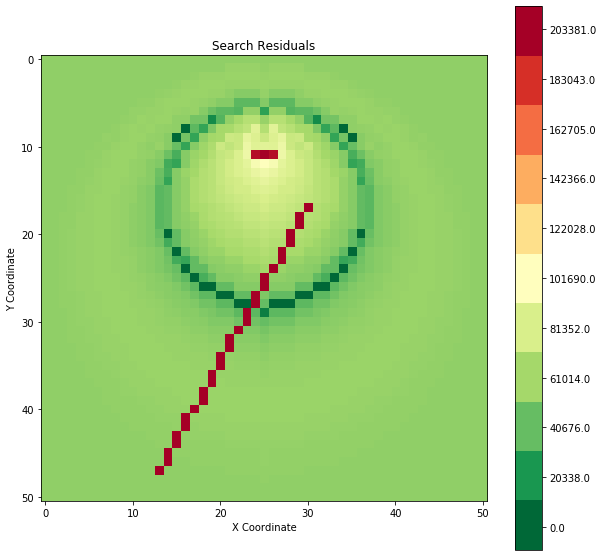

In [87]:

R = RR
stress = np.array([RR/4, 0, -RR/4]).reshape(3,1)
Stress0 = np.array([2*RR/3, 0, 0]).reshape(3,1)
dStrain = np.array([-.01, .0, .01]).reshape(3,1)

psiResiduals(stress, Stress0, dStrain, kappaM)

## Search Method

Our ability to search through this remaining discrete list to find a solution will be our computational bottleneck, it is imperative that we do it quickly. Many different methods are available for searching through what is  effectively a 1D discontinuous equation. They can be divided into two primary groups:

* 1. Discrete-native

These are search methods which are built for discrete lists (i.e. discontinous functions). Since the function is recognized as discontinuous we will be unable to rely on certain aspects of functions which are often used to create search methods (i.e. derivatives). If done properly these methods are extremely quick.

Here we will discuss a discrete-native search which evaluates coordinates sequentially, beginning at the current coordinate. This method requires no computationally expensive means of pushing itself forward, it must simply move to the next element in our list if the previous one did not contain an appropiate solution. As you may surmise, this is a very basic search, but it performs suprisingly well. 

When strain increments are small enough to only push our stress state a few coordinates away we will find our solution within a few inexpensive iterations. This results in speeds many times faster than the traditional radial map search method. Note that as strain-increments grow large enough to push the next stress-state many coordinates away (~30+) it will become slower that the traditional method. This specific search can be seen to be slow for large strain-increments but increasingly fast for small-strain increments, hence why it is a good choice for simulations where many timesteps are considered (i.e. the strain-increments are forced to be small by time discretization). In instances where few timesteps are considered we could also use a sequential search but instead begin at the farthest point and move back towards the current coordinate, effectively reversing the relationship.

* 2. Pseudo-discrete

At times it may be neccesary to use a more complex, self-adjusting search method to achieve a fast convergence. This typically involves considering the discrete list as a continuous function. While the values in the list are discrete points of a continuous function it is not accurate to use calls to the list as a proxy for the function itself (which is non-linear). In instances where minima are not expected to occur between coordinate points this is a reasonable thing to do and will often be the case for non-linear equations encountered in constitutive moels.

We will consider the Golden/Brent search method for 1D equations.

The search is the crux. Only the most basic methods have been discussed here, potentially massive increases in speed could be revealed by refined methods.

In [88]:
R = RR
#res = 101
res = res_x

stress = np.array([RR/4, 0, -RR/4]).reshape(3,1)
Stress0 = np.array([2*RR/3, 0, 0]).reshape(3,1)
dStrain = np.array([-.01, .0, .01]).reshape(3,1)

In [89]:
def searchVis(CurStress, Stress0, dStrain, kappaMatrix):

    # Enter deviatoric plane
    dev_CurStress = dev(CurStress)
    dev_NextStress0 = dev(Stress0)
    dev_dStrain = dev(dStrain)
    
    # Process resolution parameters
    res_x, res_y, cen_x, cen_y = resVals(kappaMatrix.shape)
    
    # Map to float index space
    indexCurStress = stressToIndex(dev_CurStress, res_x, res_y, RR, sliced=False) # Float index
    indexNextStress0 = stressToIndex(dev_NextStress0, res_x, res_y, RR, sliced=False) # Float index
    indexDStrain = stressToIndex(dev_dStrain, res_x, res_y, RR, sliced=False)
    indexCurStress = APiToOPi(indexCurStress, res_x) # O\Pi
    indexNextStress0 = APiToOPi(indexNextStress0, res_x) # O\Pi
    indexDStrain = APiToOPi(indexDStrain, res_x)

    # Find north angle
    north = np.array([0,1]).reshape(2,1) # O\Pi
    if np.all(indexNextStress0 == 0):
        northAngle = 0. # If zero vector stress, set angles to 0
    else:
        northAngle = angleIndex(north, indexNextStress0) # Angle of unloading stress from north
    
    # Rotated float index stress-state (O\Pi)
    indexNorthCurStress = indexRotator(indexCurStress, -northAngle)
    indexNorthNextStress0 = indexRotator(indexNextStress0, -northAngle)
    indexNorthDStrain = indexRotator(indexDStrain, -northAngle)
    
    # Convert to A\Pi
    indexNorthCurStress = OPiToAPi(indexNorthCurStress, res_x)
    indexNorthNextStress0 = OPiToAPi(indexNorthNextStress0, res_x)
    indexNorthDStrain = OPiToAPi(indexNorthDStrain, res_x)
    
    # Retrieve appropiate layer from solution matrix
    layerK = (cen_y) - int(np.round(indexNorthNextStress0[1]))
    cartK = np.array(kappaMatrix[:,:,layerK])
    
    # Find current coordinate values
    CurKappa = cartK[int(indexNorthCurStress[1]),int(indexNorthCurStress[0])]
    CurH = (CurKappa*hh)**(mm)
    
    fig = plt.figure()
    
    rr, cc = psiSearch_lite(indexNorthDStrain, indexNorthCurStress, res_x) # Retrieve coordinate lists
    
    canvas = np.zeros((res, res))
    canvas[rr,cc] = 1
    plt.imshow(canvas)
    
    
    
    
    plt.show()

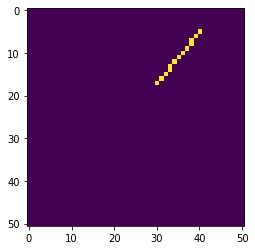

In [90]:
searchVis(stress, Stress0, dStrain, kappaM)

---
# Reformulated Radial Map

Precomputing portions of the constitutive relationship radically changes how we must program the radial map. Instead of actually solving for the parameters of each time step, we will instead focus on efficient evaluation of precomputed values.

### Strain-Driven

Six primary steps are performed for strain-driven scenarios.

 1. **Map to Access Space** -- 
Calculations in our 2D deviatoric stress index space will be more efficient than in a 3D principal normal stress space, especially for rotations. At the start of each timestep we will map all stress-strain vectors into deviatoric index space, maintaining float values, for computational purposes. Next we rotate the indexed unloading stress around the hydrostatic axis ($O\Pi$ index space origin) to be colinear with the $\Pi$-plane north unit-vector. No inaccuracies are incurred due to the model's rotational symmetry, so long as we take the rest of the current state with it (i.e. rotate current stress and the strain step by the same angle).
 2. **Access Solution Matrix** --
With the unloading stress aligned with the north unit vector, as it was in the constuction of the $\kappa$ matrix, we are able to determine the exact layer of the $\kappa$ matrix to access. We now map our stress state to integer $A\Pi$ index space to be compatible with matrix access. Since we already know our current stress position we can access the $\kappa$ matrix to retrieve our $\kappa_{n}$ value. Somewhere on this layer is the appropiate $\kappa_{n+1}$ value which, when combined with the $\kappa_{n}$ value, can be verfied as the solution. Searching the entire layer is time-intensive so we must determine some sort of geometric or probabilistic region to prioritize in the search. As this model is simple, we know that the change in deviatoric stress is always in the same direction as the change in deviatoric strain, so that line must contain the best $\kappa_{n+1}$. Our `psiSearch()` function will determine the coordinates that may contain the solution.
 3. **Determine the Appropiate Solution** --
$\kappa$ values on their own aren't enough, they are just agnostic (relative to material) scalars. We must evolve them into $H'$ by referencing our chosen hardening equation. This is typically a basic function that takes material parameters into account, but it must be performed for each coordinate iteration along the search-line. Once we have the $H'$s we can determine $\psi$. If an $H'_{n}$, $H'_{n+1}$, $\psi$ at a coordinate produce a value smaller than a chosen tolerance when plugged into the minimization equation, we know that the $\psi$ is our solution.
 4. **Solve constitutive equation** --
With our $\psi$ value retrieved we now solve the base constitutive equation, allowing for a forward step of the state. All the rotated stresses are discarded as they are no longer needed. The radial map is exited and the driver updated.


### Stress-Driven
The stress-driving scenario is identical to the strain-driving within the radial map, but will involve repeated calls to the radial map as a strain increment is varied until the goal stress state is achieved.


### Pure Stress-Driven
Pure stress driving is when a stress increment is inserted into the radial map and an updated strain state is returned. It involves 3 primary steps:

 1. Map to Access Space
 2. Access Solution matrix
 3. Solve constitutive equation

In [91]:
from skimage.draw import line

Another great aspect of this model is the simplicity of its unloading criterion. Any stress or strain increment (as they face the same direction) that points in a direction of descending $\kappa$ signals standard loading and thereby the unloading stress does not change. An increment that point tangent to a $\kappa$ contour also signifies standard loading. An increment which point in a direction of ascending $\kappa$ (e.g. towards the center of the contour) signals unloading and causes the unloading stress to reset its position to the current stress'.

In [92]:
NextStress0 = np.array([[0],[0],[0]])
CurStress = np.array([[.01],[0.005],[0]])
CurKappa = 1
dStrain = np.array([[-0.001],[0],[0]])
dStress = np.array([[-0.0001],[-0.00005],[0]])

# --------------------------------------------------------

dev_CurStress = dev(CurStress)
dev_NextStress0 = dev(NextStress0)
dev_dStrain = dev(dStrain)
dev_dStress = dev(dStress)
small = 1e-11

StressDriven = 1
#=================================
# -----UNLOADING CHECK
if StressDriven == 0:
    print('Strain-driven')
    numerator = innerProduct((-(1 + CurKappa)*dev_CurStress - CurKappa*(1 + CurKappa)*(dev_CurStress - dev_NextStress0)), dev_dStrain, 3)
    denominator = innerProduct(( (1 + CurKappa)*dev_CurStress - CurKappa*dev_NextStress0), (dev_CurStress - dev_NextStress0), 1)
elif StressDriven == 1:
    print('Stress-driven')
    numerator = innerProduct((-(1 + CurKappa)*dev_CurStress - CurKappa*(1 + CurKappa)*(dev_CurStress - dev_NextStress0)), dev_dStress, 1)
    denominator = innerProduct(( (1 + CurKappa)*dev_CurStress - CurKappa*dev_NextStress0), (dev_CurStress - dev_NextStress0), 1)

if np.absolute(denominator) < small:
    loadingCond = 0
else:
    loadingCond = numerator/denominator

if loadingCond > 0.0:
    print('Unloading Happened')
    NextStress0 = CurStress
    dev_NextStress0 = dev(NextStress0)
    loadingCond = 0
else:
    loadingCond = 0


Stress-driven
Unloading Happened


# Driver Changes

Minor changes will also be neccesary for the driving function. 

So far we've designed only for a 3D principal normal stress/strain state. While we can redo the prior work for a 3x3 or 6x1 stress/strain input, currently we must ensure that the driving stress or strain is in a 3x1 format. We can achieve this through construction or conversion, but recognize that converting into the 3x1 format may be computationally expensive, to the point where it may outweigh the speed increase of the precomputation speed.

Preserving the index coordinates of previous stress states through time steps will also be useful as it prevents the need for remapping from stress to index.

Note that while a stress-driven loading will require the $H'$ and $\psi$ matrices to function, a strain-driven loading only requires the $\psi$ matrix. Strain-driven cases also do not require iterating to find which $\psi$ value is correct (since we already know what the next stress state is).

---
# Big O Notation


The time complexity of the new radial map and driver can be assessed quantitatively. Consider the five primary components of the new model that require computational time:


$$ T(n) = O_{Radial-Map} + O_{Driver} + O_{Search-Line-Construction} + O_{Coordinate-Convergence} + O_{RAM} $$


$O_{Radial-Map}$ and $O_{Driver}$ are shown to increase linearly with the number of timesteps. 

$O_{Search-Line-Construction}$ is taken to remain a static value, $a$. 

$O_{Coordinate-Convergence}$ scales linearly with resolution. 

$O_{RAM}$ is system specific but will exhibit strange behavior, as RAM has a physical limit to the resolution of solution matrices it can access. For now we will consider that it is a function of resolution and timesteps.

$$ T(n) = O(n) + O(n) + O(f(r,n)) + a + O(r*n) = O(r*n) + O \left( f(r,n) \right) $$

Experimentally, the RAM will produce a near-negligible amount of impedence if resolution is kept within a reasonable range, $[0,r_{max}]$. While this $r_{max}$ term is not precisly known its true maximum in this implementation can be taken to be the cube root of twice the systems total available RAM divided by the digital space occupied by a single element of the solution matrix (dependent on integer or float, decimal points, etc.)

$$ S_{Available} = S_{Total} - S_{Used} $$

Where $S_{Used}$ is any RAM space that must be reserved for running the operating system, the rest of the driver/radial map, or other neccesary processes. 

$$ S_{Available} = S_{Element} \left( r_{max} * r_{max} * \frac{r_{max}}{2} \right) $$

$$ r_{max} = \sqrt[3]{ 2 \frac{S_{Available}}{S_{Element}} }  $$

We then assume that within this usable range of resolutions that $O_{RAM}$ is fairly static. In reality it may behave nonlinearly, but this will do for now.

Therefore

$ T(n) = O(r*n) + O( f(r,n) ) = O(r*n) + c = O(n) $,   where  $ r \in [0,r_{max}]$

$ T(n) \in O(n) $,   where  $ r \in [0,r_{max}]$


The time complexity of the new precomputed radial map and driver is of the order $n$. Time complexity is also found to not depend on resolution while it remains within the usuable resolution range.

Keep in mind that many scalar factors were neglected, due to Big O notation, which can be influential at the relatively low number of timesteps and and coarse resolutions we use. Nevertheless, it appears that the precomputation method will only become more efficient in comparison to traditional methods as timesteps increase. Traditional methods rely on variations of Newton-Raphson convergence, whose time complexity is taken to be on the order of $n^2$.

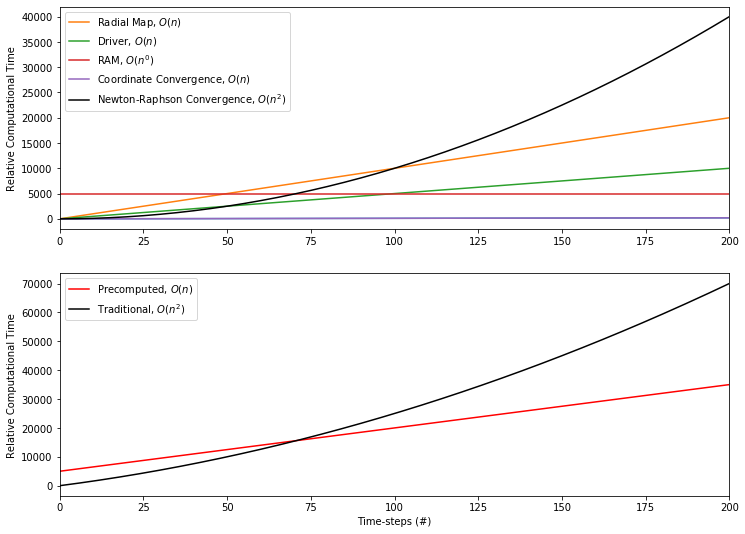

In [93]:
nPoints = 200

fig, axes = plt.subplots(2, figsize=(12,9))


a, b, c, d = 100, 50, 5000, 1

x = np.linspace(0,nPoints, nPoints+1)

y = x
cy = [c]*len(x)
yy = x**2


axes[0].plot(x, y)
axes[0].plot(x, a*y, label='Radial Map, $O(n)$')
axes[0].plot(x, b*y, label='Driver, $O(n)$')
axes[0].plot(x, cy, label='RAM, $O(n^0)$')
axes[0].plot(x, d*y, label='Coordinate Convergence, $O(n)$')
axes[0].plot(x, yy, color='black', label='Newton-Raphson Convergence, $O(n^2)$')
axes[0].set_xlim(0,max(x))
axes[0].set_ylabel('Relative Computational Time')
axes[0].legend()

axes[1].plot(x, a*y + b*y + cy, color='red', label='Precomputed, $O(n)$')
axes[1].plot(x,yy + a*y + b*y, color='black', label='Traditional, $O(n^2)$')
axes[1].set_xlim(0,max(x))
axes[1].set_xlabel('Time-steps (#)')
axes[1].set_ylabel('Relative Computational Time')
axes[1].legend()

plt.show()

---
# Test and Benchmark

In [98]:
# Import drivers and radial maps
%run ./Arduino.ipynb

Run the driver.

In [99]:
%%time
out = psiBSDriver(2)

CPU times: user 2.18 s, sys: 0 ns, total: 2.18 s
Wall time: 2.18 s


Now we can call our animation function to show us the stress path resulting from loading. This can take a few minutes on weaker computers, Lower nPoints to speed it up

In [100]:
#animateDeviatoricSurface(out.time, out.Stress0, out.stress, out.StaticParam.Su)

Seperating the stress and strain path by time produces the following plots.

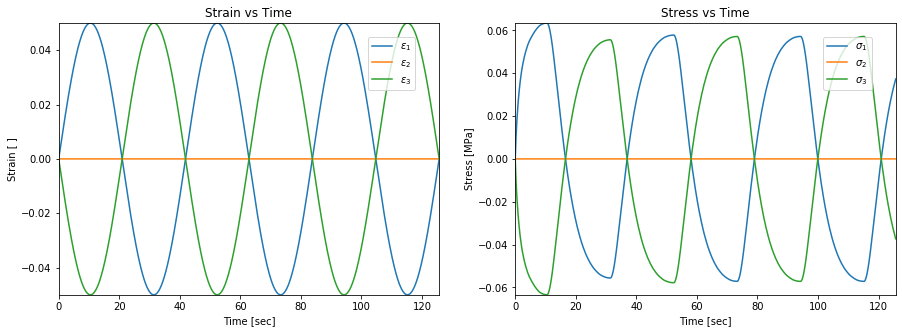

In [101]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].plot(out.time, out.strain[0], label='$\epsilon_1$') 
axes[0].plot(out.time, out.strain[1], label='$\epsilon_2$') 
axes[0].plot(out.time, out.strain[2], label='$\epsilon_3$') 

axes[0].set_title('Strain vs Time')
axes[0].set_xlabel('Time [sec]')
axes[0].set_ylabel('Strain [ ]')
axes[0].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[0].set_xlim(0, out.time.max())
axes[0].set_ylim(out.strain.min(), out.strain.max())

axes[1].plot(out.time, out.stress[0], label='$\sigma_{1}$') 
axes[1].plot(out.time, out.stress[1], label='$\sigma_{2}$') 
axes[1].plot(out.time, out.stress[2], label='$\sigma_{3}$') 

axes[1].set_title('Stress vs Time')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Stress [MPa]')
axes[1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[1].set_xlim(0, out.time.max())
axes[1].set_ylim(out.stress.min(), out.stress.max())


plt.show()

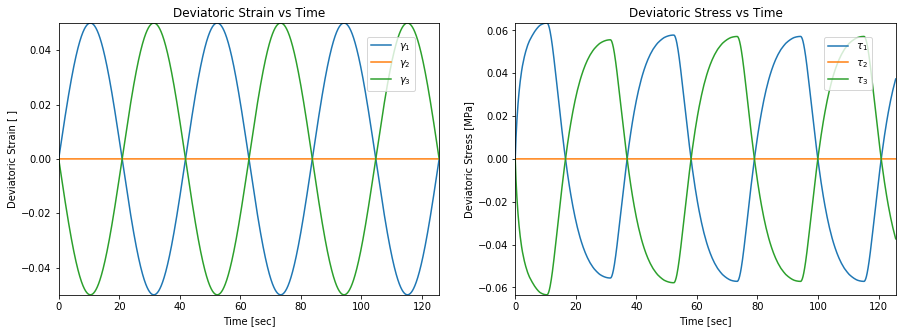

In [102]:
# Process deviatoric and volumetric stresses/strains
dev_strain, vol_strain = np.zeros((3,len(out.time))),np.zeros((3,len(out.time)))
dev_stress, vol_stress = np.zeros((3,len(out.time))),np.zeros((3,len(out.time)))
for i in range(len(out.time)):
    dev_strain[:,i] = dev(out.strain[:,i].reshape(3,1)).reshape(3,)
    vol_strain[:,i] = trace(out.strain[:,i].reshape(3,1))
    dev_stress[:,i] = dev(out.stress[:,i].reshape(3,1)).reshape(3,)
    vol_stress[:,i] = trace(out.stress[:,i].reshape(3,1))
    
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].plot(out.time, dev_strain[0], label='$\gamma_{1}$') 
axes[0].plot(out.time, dev_strain[1], label='$\gamma_{2}$') 
axes[0].plot(out.time, dev_strain[2], label='$\gamma_{3}$') 

axes[0].set_title('Deviatoric Strain vs Time')
axes[0].set_xlabel('Time [sec]')
axes[0].set_ylabel('Deviatoric Strain [ ]')
axes[0].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[0].set_xlim(0, out.time.max())
axes[0].set_ylim(dev_strain.min(), dev_strain.max())

axes[1].plot(out.time, dev_stress[0], label='$\N{greek small letter tau}_{1}$') 
axes[1].plot(out.time, dev_stress[1], label='$\N{greek small letter tau}_{2}$') 
axes[1].plot(out.time, dev_stress[2], label='$\N{greek small letter tau}_{3}$') 

axes[1].set_title('Deviatoric Stress vs Time')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Deviatoric Stress [MPa]')
axes[1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[1].set_xlim(0, out.time.max())
axes[1].set_ylim(dev_stress.min(), dev_stress.max())

plt.show()

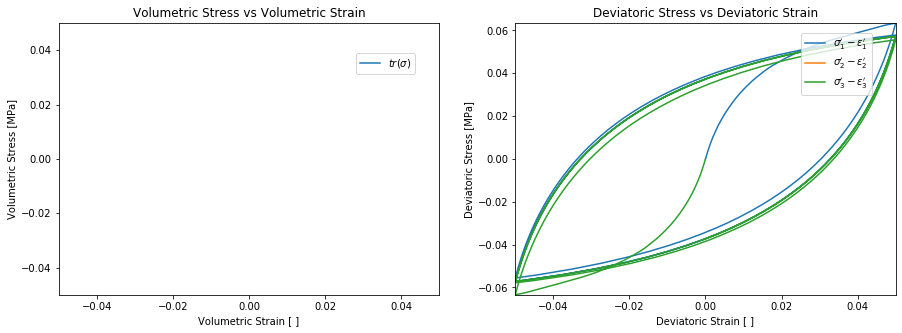

In [103]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].plot(vol_strain[0], vol_stress[0], label='$tr(\sigma)$') 
axes[0].plot(vol_strain[1], vol_stress[1]) 
axes[0].plot(vol_strain[2], vol_stress[2]) 

axes[0].set_title('Volumetric Stress vs Volumetric Strain')
axes[0].set_xlabel('Volumetric Strain [ ]')
axes[0].set_ylabel('Volumetric Stress [MPa]')
axes[0].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[0].set_xlim(vol_strain.min(), vol_strain.max())
axes[0].set_ylim(vol_stress.min(), vol_stress.max())

axes[1].plot(dev_strain[0], dev_stress[0], label='$\sigma_{1}\'-\epsilon_{1}\'$') 
axes[1].plot(dev_strain[1], dev_stress[1], label='$\sigma_{2}\'-\epsilon_{2}\'$') 
axes[1].plot(dev_strain[2], dev_stress[2], label='$\sigma_{3}\'-\epsilon_{3}\'$') 

axes[1].set_title('Deviatoric Stress vs Deviatoric Strain')
axes[1].set_xlabel('Deviatoric Strain [ ]')
axes[1].set_ylabel('Deviatoric Stress [MPa]')
axes[1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")  # Legend outside plot
axes[1].set_xlim(dev_strain.min(), dev_strain.max())
axes[1].set_ylim(dev_stress.min(), dev_stress.max())

plt.show()

Keep in mind that all the driver and radial map are doing is retrieving a $\psi$ value for use in calculating the next stress/strain state. Taking a closer look at the $\kappa$, $H'$, and $\psi$ value of each step gives a better idea of how logically the driver is performing. Each value should be near its peak whenever the model unloads, and should decrease the farther away from the unloading point that the stress moves.

For strain-driving cases, monitor the iterations to see where the program has to spend more time in finding the $\psi$-$H'$ pair. It should normally be where the stress is moving a larger distance.

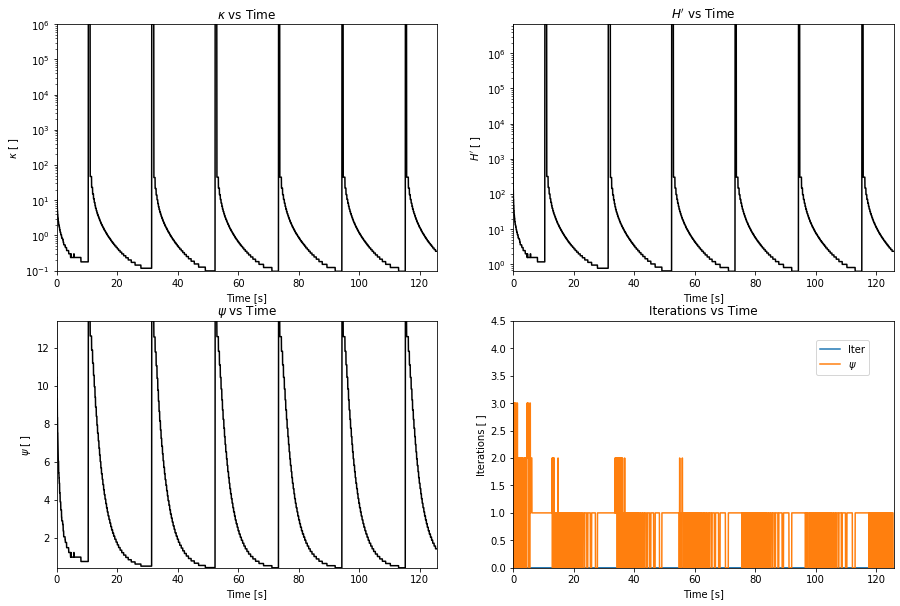

In [104]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(out.time, out.kappa, color='black')
axes[0, 0].set_title('$\kappa$ vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('$\kappa$ [ ]')
axes[0, 0].set_xlim(out.time.min(), out.time.max())
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(min(out.kappa), max(out.kappa))

axes[0, 1].plot(out.time, out.H, color='black')
axes[0, 1].set_title('$H\'$ vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('$H\'$ [ ]')
axes[0, 1].set_xlim(out.time.min(), out.time.max())
axes[0, 1].set_yscale('log')
axes[0, 1].set_ylim(min(out.H), max(out.H))

axes[1, 0].plot(out.time, out.psi, color='black')
axes[1, 0].set_title('$\psi$ vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('$\psi$ [ ]')
axes[1, 0].set_xlim(out.time.min(), out.time.max())
axes[1, 0].set_ylim(min(out.psi), 2*out.StaticParam.G)

#axes[1, 1].set_yscale('log')
#axes[1, 1].plot(out.time, out.Iter_H, label = '$H\'$')
axes[1, 1].plot(out.time, out.Iter, label='Iter')
axes[1, 1].plot(out.time, out.Iter_Psi, label = '$\psi$')
axes[1, 1].set_title('Iterations vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Iterations [ ]')
axes[1, 1].set_xlim(out.time.min(), out.time.max())
axes[1, 1].set_ylim(0, 1.5*max(max(out.Iter),max(out.Iter_Psi)))
axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")

plt.show()

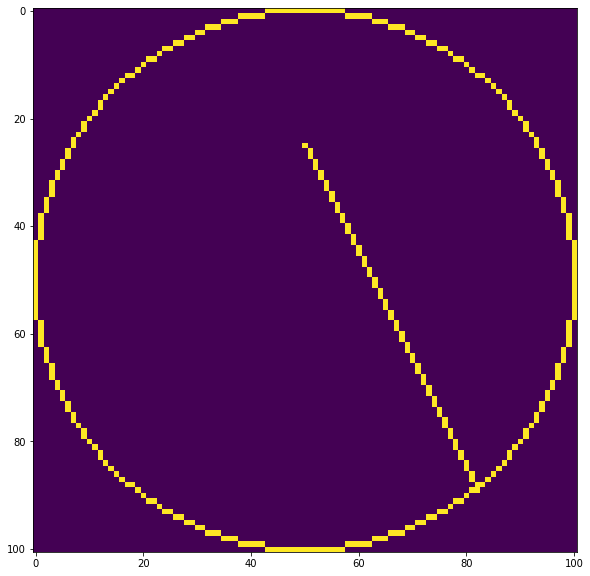

In [105]:
from skimage.draw import circle_perimeter
from skimage.draw import line
res = 101
cen = int(np.floor(res/2))
CurStress = np.array([cen,cen-int(cen/2)]).reshape(2,1)
dStrain = np.array([.0005,-.001]).reshape(2,1)
rr, cc = psiSearch_lite(dStrain, CurStress, res)

fig = plt.figure(figsize=(10,10))

canvas = np.zeros((res,res), dtype=np.uint8)
circ = circle_perimeter(r=cen,c=cen,radius=cen)
canvas[rr,cc]=1
canvas[circ]=1


plt.imshow(canvas)

plt.show()

In [106]:
def min_target(x):
    # Minimizing the residual of this function reveals best solution
    # x: Point in search list to evaluate, scalar
    
    # Discretize input for use in search list
    idx = int(np.round(x))
    if idx >= len(rr):
        idx = len(rr)-1 # Clamp
    
    # Choose coordinate to evaluate
    j = rr[idx]
    i = cc[idx]
    
    # Cooridinate specific values
    NextKappa = np.array(kappaM[j,i,layerK])
    NextH = float((NextKappa*hh)**(mm)) # Compute hardening moduli
    if NextH == 0:
        NextH = small # Prevent div\0 issues
    
    # Coordinate pair specific \psi value
    psi = (2*G) / (1 + 3*G*((1-beta)/NextH + beta/NextH))
    
    # Solve base equation, zero res_R means pair matches true function (i.e. no error)
    res_R = np.abs(vectorNorm(dev_CurStress + psi*dev_dStrain + NextKappa*(dev_CurStress + psi*dev_dStrain - dev_NextStress0),1) - R)

    return res_R

In [109]:
from scipy.optimize import minimize_scalar
res = 201
cen = int(np.floor(res/2))

res_x = res
res_y = res
cen_x = cen
cen_y = cen

NextStress0 = np.array([R/2,0,0]).reshape(3,1)
CurStress = np.array([R/5,0,0]).reshape(3,1)
dStrain = np.array([-0.0000001,0,0]).reshape(3,1)

dev_NextStress0 = dev(NextStress0)
dev_CurStress = dev(CurStress)
dev_dStrain = dev(dStrain)

# A\Pi
indexNorthNextStress0 = stressToIndex(dev_NextStress0,res_x,res_y,R)
indexNorthCurStress = stressToIndex(dev_CurStress,res_x,res_y,R)
indexNorthDStrain = stressToIndex(dev_dStrain,res_x,res_y,R)

layerK = cen - int(np.round(indexNorthNextStress0[1]))
print('k',k)

kappaM = loadKappa(res,res)
rr, cc = psiSearch_lite(indexNorthDStrain, indexNorthCurStress, res)

# Current coordinate specific values
i = int(np.array(indexNorthCurStress[0]))
j = int(np.array(indexNorthCurStress[1]))

CurKappa = np.array(kappaM[i,j,layerK])
CurH = float((CurKappa*hh)**mm)

NameError: name 'k' is not defined

In [110]:
from scipy.optimize import bracket

extent = (0, 2) # Bound the 1D evaluation area to the coordinate list

opt = {'maxiter': 50}
sol = minimize_scalar(min_target, bounds=extent, options = opt, method='bounded') # Minimize residual function
print(sol)

idx = int(np.round(sol.x))
if idx >= len(rr):
    idx = idx-1
    
NextKappa = np.array(kappaM[rr[idx],cc[idx],k])
NextH = float(hh*NextKappa**mm)
psi = (2*G) / (1 + 3*G*((1-beta)/NextH + beta/NextH))
print('')
print('CurKappa:',CurKappa)
print('NextKappa:',NextKappa)
print('psi:', psi)

IndexError: index 51 is out of bounds for axis 1 with size 51

<IPython.core.display.Javascript object>


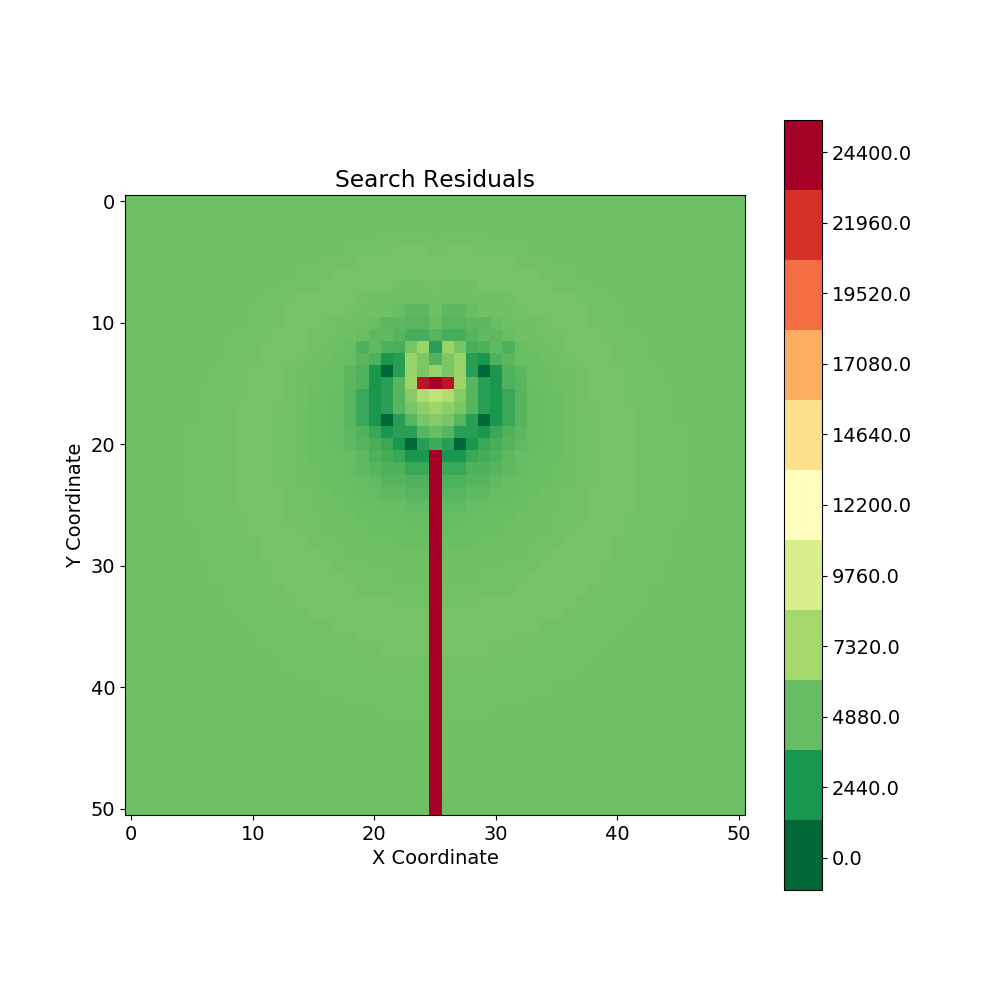

In [111]:
psiResiduals(CurStress, NextStress0, dStrain, kappaM)

---
# Comparison

If the new driver isn't faster, all of this work was for nothing. First, let's take a look at how the old driver fares for a variety of load cases.

In [135]:
%matplotlib inline

In [136]:
# Import traditional driver and radial map
%run ./Arduino.ipynb
%run ./Precomputed.ipynb
%run ./Utilities.ipynb

Some scale issues are occurring in the new driver which are being worked on (likely caused by x2 factor from stress-strain), for now stick to loads 2 and 4 or swap out the final constitutive calculation line in the radial map (both stress and strain case) for the adjacent commented one for monotonic loads.

In [137]:
res_x = 51
res_y = res_x

In [138]:
kappaM = loadKappa(res_x,res_x)
res_x, res_y, cen_x, cen_y = resVals(kappaM.shape)

Loaded array kappaMatrix into RAM, shape: (51, 51, 26)


In [139]:
# load = 1: Monotonic Strain
# load = 2: Cyclic Strain
# load = 3: Monotonic Stress
# load = 4: Cyclic Stress
# ==========================
load = 2
n = 5
f = 1

In [140]:
print('Run old driver...')
%timeit -r 1 -n 1 BSDriver(load)
old = BSDriver(load) # Driver
print('Old driver finished.')

Run old driver...
18.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Old driver finished.


The original driver outputs in 6x1 format. The following cell will convert to principal stress/strain for consistency.

In [141]:
# Convert 6x1 stress and strains to 3x1 principal normal form
prinStress = np.zeros((3,old.stress.shape[1]))
prinStrain = np.zeros((3,old.strain.shape[1]))
for i in range(0,old.strain.shape[1]):
    #prinStress[:,i] = sixToPrincipal(old.stress[:,i]).ravel() # Reformat 3x1 
    #prinStrain[:,i] = sixToPrincipal(old.strain[:,i]).ravel() # Reformat 3x1
    
    p1, p2, p3 = princVal(old.stress[:,i].reshape(6,1), type=0)
    prinStress[:,i] = np.array([p1,p2,p3])
    p1, p2, p3 = princVal(old.strain[:,i].reshape(6,1), type=0)
    prinStrain[:,i] = np.array([p1,p2,p3])

Now we will run the new driver. 

In [142]:
print('Run new driver...')
%timeit -r 1 -n 1 psiBSDriver(load)
new = psiBSDriver(load) # Driver using precomputation
print('New driver finished.')

Run new driver...
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
New driver finished.


We can calculate the error between the drivers as follows.

In [143]:
# Raw error
errStress = (np.abs(new.stress) - np.abs(prinStress) )
errStrain = (np.abs(new.strain) - np.abs(prinStrain) )

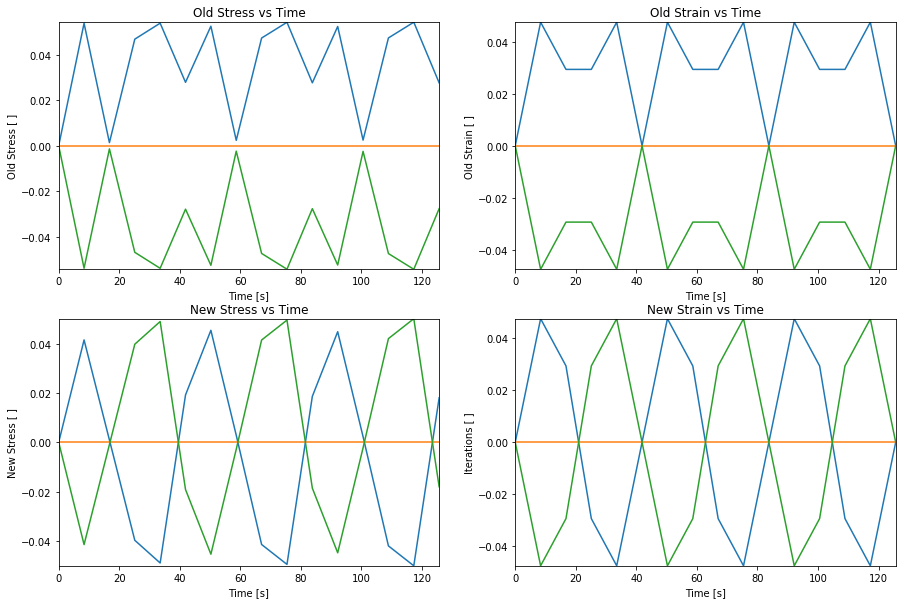

In [144]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old.time, prinStress[0])
axes[0, 0].plot(old.time, prinStress[1])
axes[0, 0].plot(old.time, prinStress[2])
axes[0, 0].set_title('Old Stress vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Old Stress [ ]')
axes[0, 0].set_xlim(old.time.min(), old.time.max())
axes[0, 0].set_ylim(prinStress.min(), prinStress.max())

axes[0, 1].plot(old.time, prinStrain[0])
axes[0, 1].plot(old.time, prinStrain[1])
axes[0, 1].plot(old.time, prinStrain[2])
axes[0, 1].set_title('Old Strain vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Old Strain [ ]')
axes[0, 1].set_xlim(old.time.min(), old.time.max())
axes[0, 1].set_ylim(prinStrain.min(), prinStrain.max())

axes[1, 0].plot(new.time, new.stress[0])
axes[1, 0].plot(new.time, new.stress[1])
axes[1, 0].plot(new.time, new.stress[2])
axes[1, 0].set_title('New Stress vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('New Stress [ ]')
axes[1, 0].set_xlim(new.time.min(), new.time.max())
axes[1, 0].set_ylim(new.stress.min(), new.stress.max())

axes[1, 1].plot(new.time, new.strain[0])
axes[1, 1].plot(new.time, new.strain[1])
axes[1, 1].plot(new.time, new.strain[2])
axes[1, 1].set_title('New Strain vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Iterations [ ]')
axes[1, 1].set_xlim(new.time.min(), new.time.max())
axes[1, 1].set_ylim(new.strain.min(), new.strain.max())
#axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")
#print(Iter_H)
plt.show()

No handles with labels found to put in legend.


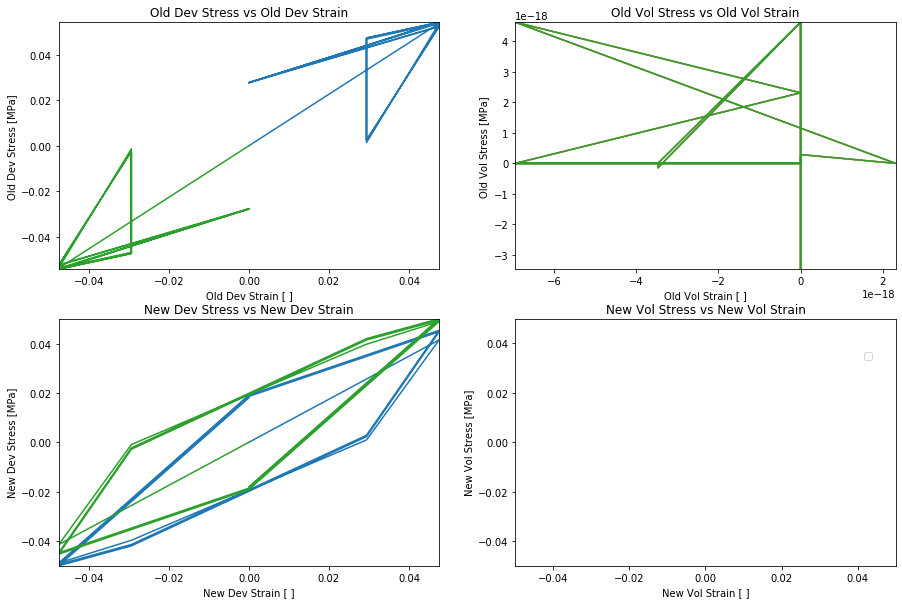

In [145]:
old_dev_strain, old_vol_strain = np.zeros((3,len(old.time))),np.zeros((3,len(old.time)))
old_dev_stress, old_vol_stress = np.zeros((3,len(old.time))),np.zeros((3,len(old.time)))
old_j2, new_j2 = [], []
for i in range(len(old.time)):
    old_dev_strain[:,i] = dev(prinStrain[:,i].reshape(3,1)).ravel()
    old_vol_strain[:,i] = trace(prinStrain[:,i].reshape(3,1))*np.array([[1/3],[1/3],[1/3]]).ravel()
    old_dev_stress[:,i] = dev(prinStress[:,i].reshape(3,1)).ravel()
    old_vol_stress[:,i] = trace(prinStress[:,i].reshape(3,1))*np.array([[1/3],[1/3],[1/3]]).ravel()
    old_j2.append(innerProduct(old_dev_stress[:,i],old_dev_stress[:,i],1))
    
new_dev_strain, new_vol_strain = np.zeros((3,len(new.time))),np.zeros((3,len(new.time)))
new_dev_stress, new_vol_stress = np.zeros((3,len(new.time))),np.zeros((3,len(new.time)))
for i in range(len(new.time)):
    new_dev_strain[:,i] = dev(new.strain[:,i].reshape(3,1)).ravel()
    new_vol_strain[:,i] = trace(new.strain[:,i].reshape(3,1))*np.array([[1/3],[1/3],[1/3]]).ravel()
    new_dev_stress[:,i] = dev(new.stress[:,i].reshape(3,1)).ravel()
    new_vol_stress[:,i] = trace(new.stress[:,i].reshape(3,1))*np.array([[1/3],[1/3],[1/3]]).ravel()
    new_j2.append(innerProduct(new_dev_stress[:,i],new_dev_stress[:,i],1))
    
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old_dev_strain[0], old_dev_stress[0])
axes[0, 0].plot(old_dev_strain[1], old_dev_stress[1])
axes[0, 0].plot(old_dev_strain[2], old_dev_stress[2])
axes[0, 0].set_title('Old Dev Stress vs Old Dev Strain')
axes[0, 0].set_xlabel('Old Dev Strain [ ]')
axes[0, 0].set_ylabel('Old Dev Stress [MPa]')
axes[0, 0].set_xlim(old_dev_strain.min(), old_dev_strain.max())
axes[0, 0].set_ylim(np.nanmin(old_dev_stress), np.nanmax(old_dev_stress))

axes[0, 1].plot(old_vol_strain[0], old_vol_stress[0])
axes[0, 1].plot(old_vol_strain[1], old_vol_stress[1])
axes[0, 1].plot(old_vol_strain[2], old_vol_stress[2])
axes[0, 1].set_title('Old Vol Stress vs Old Vol Strain')
axes[0, 1].set_xlabel('Old Vol Strain [ ]')
axes[0, 1].set_ylabel('Old Vol Stress [MPa]')
axes[0, 1].set_xlim(old_vol_strain.min(), old_vol_strain.max())
axes[0, 1].set_ylim(np.nanmin(old_vol_stress), np.nanmax(old_vol_stress))

axes[1, 0].plot(new_dev_strain[0], new_dev_stress[0])
axes[1, 0].plot(new_dev_strain[1], new_dev_stress[1])
axes[1, 0].plot(new_dev_strain[2], new_dev_stress[2])
axes[1, 0].set_title('New Dev Stress vs New Dev Strain')
axes[1, 0].set_xlabel('New Dev Strain [ ]')
axes[1, 0].set_ylabel('New Dev Stress [MPa]')
axes[1, 0].set_xlim(new_dev_strain.min(), new_dev_strain.max())
axes[1, 0].set_ylim(new_dev_stress.min(), new_dev_stress.max())

axes[1, 1].plot(new_vol_strain[0], new_vol_stress[0])
axes[1, 1].plot(new_vol_strain[1], new_vol_stress[1])
axes[1, 1].plot(new_vol_strain[2], new_vol_stress[2])
axes[1, 1].set_title('New Vol Stress vs New Vol Strain')
axes[1, 1].set_xlabel('New Vol Strain [ ]')
axes[1, 1].set_ylabel('New Vol Stress [MPa]')
axes[1, 1].set_xlim(new_vol_strain.min(), new_vol_strain[2].max())
axes[1, 1].set_ylim(new_vol_stress.min(), new_vol_stress.max())
axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")

plt.show()

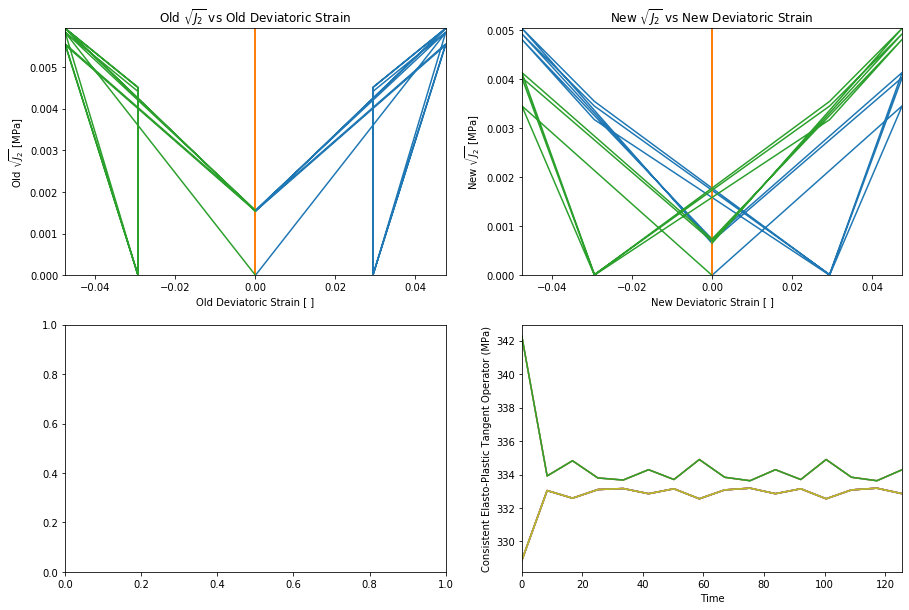

In [146]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old_dev_strain[0], old_j2)
axes[0, 0].plot(old_dev_strain[1], old_j2)
axes[0, 0].plot(old_dev_strain[2], old_j2)
axes[0, 0].set_title('Old $\sqrt{J_2}$ vs Old Deviatoric Strain')
axes[0, 0].set_xlabel('Old Deviatoric Strain [ ]')
axes[0, 0].set_ylabel('Old $\sqrt{J_2}$ [MPa]')
axes[0, 0].set_xlim(old_dev_strain.min(), old_dev_strain.max())
axes[0, 0].set_ylim(min(old_j2), max(old_j2))

axes[0, 1].plot(new_dev_strain[0], new_j2)
axes[0, 1].plot(new_dev_strain[1], new_j2)
axes[0, 1].plot(new_dev_strain[2], new_j2)
axes[0, 1].set_title('New $\sqrt{J_2}$ vs New Deviatoric Strain')
axes[0, 1].set_xlabel('New Deviatoric Strain [ ]')
axes[0, 1].set_ylabel('New $\sqrt{J_2}$ [MPa]')
axes[0, 1].set_xlim(new_dev_strain.min(), new_dev_strain.max())
axes[0, 1].set_ylim(min(new_j2), max(new_j2))

C = np.asarray(new.C)
axes[1,1].plot(new.time, C[0:len(new.time),0,0])
axes[1,1].plot(new.time, C[0:len(new.time),1,1])
axes[1,1].plot(new.time, C[0:len(new.time),2,2])
axes[1,1].plot(new.time, C[0:len(new.time),0,1])
axes[1,1].plot(new.time, C[0:len(new.time),1,2])
axes[1,1].plot(new.time, C[0:len(new.time),0,2])
axes[1,1].plot(new.time, C[0:len(new.time),1,0])
axes[1,1].plot(new.time, C[0:len(new.time),2,1])
axes[1,1].plot(new.time, C[0:len(new.time),2,0])
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Consistent Elasto-Plastic Tangent Operator (MPa)')
axes[1,1].set_xlim(0,max(new.time))

plt.show()

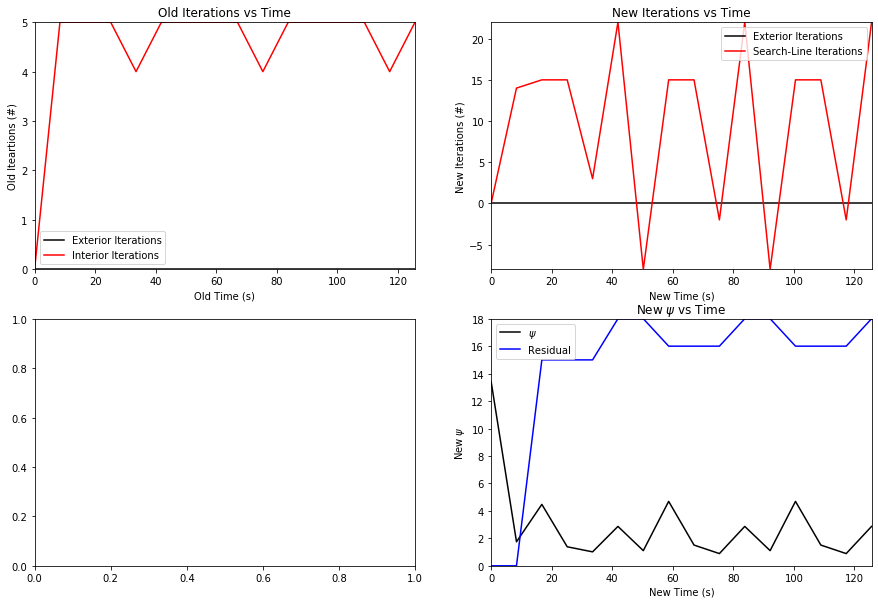

In [147]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old.time, old.Iter, color='black', label='Exterior Iterations')
axes[0, 0].plot(old.time, old.Iter_Inner, color='red', label='Interior Iterations')
axes[0, 0].set_title('Old Iterations vs Time')
axes[0, 0].set_xlabel('Old Time (s)')
axes[0, 0].set_ylabel('Old Iteartions (#)')
axes[0, 0].set_xlim(min(old.time), max(old.time))
axes[0, 0].set_ylim(0, max(max(old.Iter_Inner),max(old.Iter)))
axes[0, 0].legend()

axes[0, 1].plot(new.time, new.Iter, color='black', label='Exterior Iterations')
axes[0, 1].plot(new.time, new.Iter_Psi, color='red', label='Search-Line Iterations')
#axes[0, 1].plot(new.time, new.Iter_H)
axes[0, 1].set_title('New Iterations vs Time')
axes[0, 1].set_xlabel('New Time (s)')
axes[0, 1].set_ylabel('New Iterations (#)')
axes[0, 1].set_xlim(min(new.time), max(new.time))
axes[0, 1].set_ylim(min(0, min(new.Iter_Psi)), max(max(new.Iter_Psi), max(new.Iter)))
axes[0, 1].legend()

axes[1, 1].plot(new.time, new.psi, color='black', label='$\psi$')
axes[1, 1].plot(new.time, new.Iter_H, color='blue', label='Residual')
axes[1, 1].set_title('New $\psi$ vs Time')
axes[1, 1].set_xlabel('New Time (s)')
axes[1, 1].set_ylabel('New $\psi$')
axes[1, 1].set_xlim(min(new.time), max(new.time))
axes[1, 1].set_ylim(0, max(2*G,max(new.Iter_H)))
axes[1, 1].legend()

plt.show()

## Analyzing Error

Note that most error (especially in cyclic loading cases) is derived from a slight 'phase-shift'.

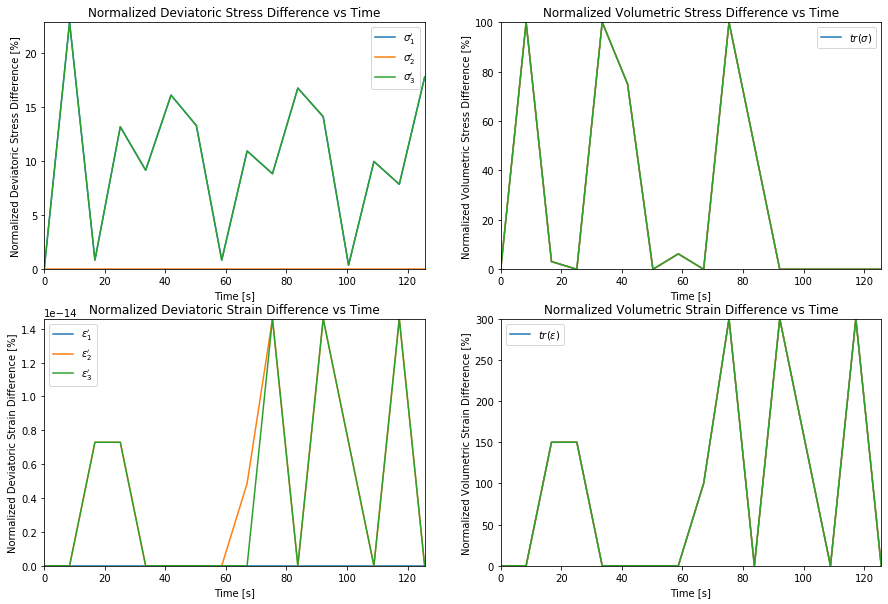

In [148]:
# Normalize deviatoric and volumetric stress/strain errors
devErrStrain = np.abs(np.abs(old_dev_strain)-np.abs(new_dev_strain))
volErrStrain = np.abs(np.abs(old_vol_strain)-np.abs(new_vol_strain))
devErrStress = np.abs(np.abs(old_dev_stress)-np.abs(new_dev_stress))
volErrStress = np.abs(np.abs(old_vol_stress)-np.abs(new_vol_stress))

normDevErrStrain = np.zeros((prinStrain.shape[0],prinStrain.shape[1]))
normVolErrStrain = np.zeros((prinStrain.shape[0],prinStrain.shape[1]))
normDevErrStress = np.zeros((prinStrain.shape[0],prinStrain.shape[1]))
normVolErrStress = np.zeros((prinStrain.shape[0],prinStrain.shape[1]))
for i in range(0, old.stress.shape[1]):
    normDevErrStrain[:,i] = 100*devErrStrain[:,i]/old_dev_strain.max()
    normVolErrStrain[:,i] = 100*volErrStrain[:,i]/old_vol_strain.max()
    normDevErrStress[:,i] = 100*devErrStress[:,i]/old_dev_stress.max()
    normVolErrStress[:,i] = 100*volErrStress[:,i]/old_vol_stress.max()

fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old.time, normDevErrStress[0], label='$\sigma_{1}\'$')
axes[0, 0].plot(old.time, normDevErrStress[1], label='$\sigma_{2}\'$')
axes[0, 0].plot(old.time, normDevErrStress[2], label='$\sigma_{3}\'$')
axes[0, 0].set_title('Normalized Deviatoric Stress Difference vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Normalized Deviatoric Stress Difference [%]')
axes[0, 0].set_xlim(old.time.min(), old.time.max())
axes[0, 0].set_ylim(np.nanmin(normDevErrStress), np.nanmax(normDevErrStress))
axes[0, 0].legend()

axes[0, 1].plot(old.time, normVolErrStress[0], label='$tr(\sigma)$')
axes[0, 1].plot(old.time, normVolErrStress[1])
axes[0, 1].plot(old.time, normVolErrStress[2])
axes[0, 1].set_title('Normalized Volumetric Stress Difference vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Normalized Volumetric Stress Difference [%]')
axes[0, 1].set_xlim(old.time.min(), old.time.max())
axes[0, 1].set_ylim(normVolErrStress.min(), normVolErrStress.max())
axes[0, 1].legend()

axes[1, 0].plot(old.time, normDevErrStrain[0], label='$\epsilon_{1}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[1], label='$\epsilon_{2}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[2], label='$\epsilon_{3}\'$')
axes[1, 0].set_title('Normalized Deviatoric Strain Difference vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Normalized Deviatoric Strain Difference [%]')
axes[1, 0].set_xlim(old.time.min(), old.time.max())
axes[1, 0].set_ylim(np.nan_to_num(normDevErrStrain.min()), np.nan_to_num(normDevErrStrain.max()))
axes[1, 0].legend()

axes[1, 1].plot(old.time, normVolErrStrain[0], label='$tr(\epsilon)$')
axes[1, 1].plot(old.time, normVolErrStrain[1])
axes[1, 1].plot(old.time, normVolErrStrain[2])
axes[1, 1].set_title('Normalized Volumetric Strain Difference vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Normalized Volumetric Strain Difference [%]')
axes[1, 1].set_xlim(old.time.min(), old.time.max())
axes[1, 1].set_ylim(np.nan_to_num(normVolErrStrain.min()), np.nan_to_num(normVolErrStrain.max()))
axes[1, 1].legend()

plt.show()

---

# Varying Resolution and Time-Steps

The conclusions drawn in the 'Big O' section can be proven experimentally. As we increase the time-steps we will see that the precomputed method becomes increasingly more efficient in comparison to the traditional. Also, the resolution of our solution matrice is mostly irrelevant granted that we keep it from occupying excessive RAM space that it interferes with computations.

In [149]:
# Import traditional driver and radial map
%run ./Arduino.ipynb

In [150]:
nList = [1, 10, 100, 1000] # List of nPoints to evaluate
rList = [51] # List of solution matrix resolutions to evaluate
loadList = [1,2,3,4] # List of loadcases to evaluate

In [151]:
import time

k = 0
oldTime, newTime = np.zeros((len(loadList),len(nList),len(rList))), np.zeros((len(loadList),len(nList),len(rList)))
for r in rList:
    res_x = r
    res_y = r
    res_z = int(np.floor(r/2)) + 1
    print('Resolution:', res_y,'x',res_x,'x',res_z)
    
    # Read the solution matrix from disk
    fn = 'kappaMatrix_' + str(res_y) + '_' + str(res_x) + '.txt'
    kappaM = np.loadtxt(fn).reshape((res_y,res_x,res_z)) # Returns 3D array
    
    i = 0
    for l in loadList:
        print('Load Case: ', l)
        oldT, newT = [],[]
        for n in nList:
            # Traditional Driver
            start = time.time()
            old = BSDriver(l)
            end = time.time()
            oldT.append(end - start)

            # Precomputed Driver
            start = time.time()
            new = psiBSDriver(l)
            end = time.time()
            newT.append(end - start)
            print('Completed: nPoints = ', n)
            
        oldTime[i,:,k] = oldT
        newTime[i,:,k] = newT
        i += 1
        print('')
        
    k += 1
    print('')

Resolution: 51 x 51 x 26
Load Case:  1
Completed: nPoints =  1
Completed: nPoints =  10
Completed: nPoints =  100
Completed: nPoints =  1000

Load Case:  2
Completed: nPoints =  1
Completed: nPoints =  10
Completed: nPoints =  100
Completed: nPoints =  1000

Load Case:  3
Completed: nPoints =  1
Completed: nPoints =  10
Completed: nPoints =  100
Completed: nPoints =  1000

Load Case:  4
Completed: nPoints =  1
Completed: nPoints =  10
Completed: nPoints =  100
Completed: nPoints =  1000




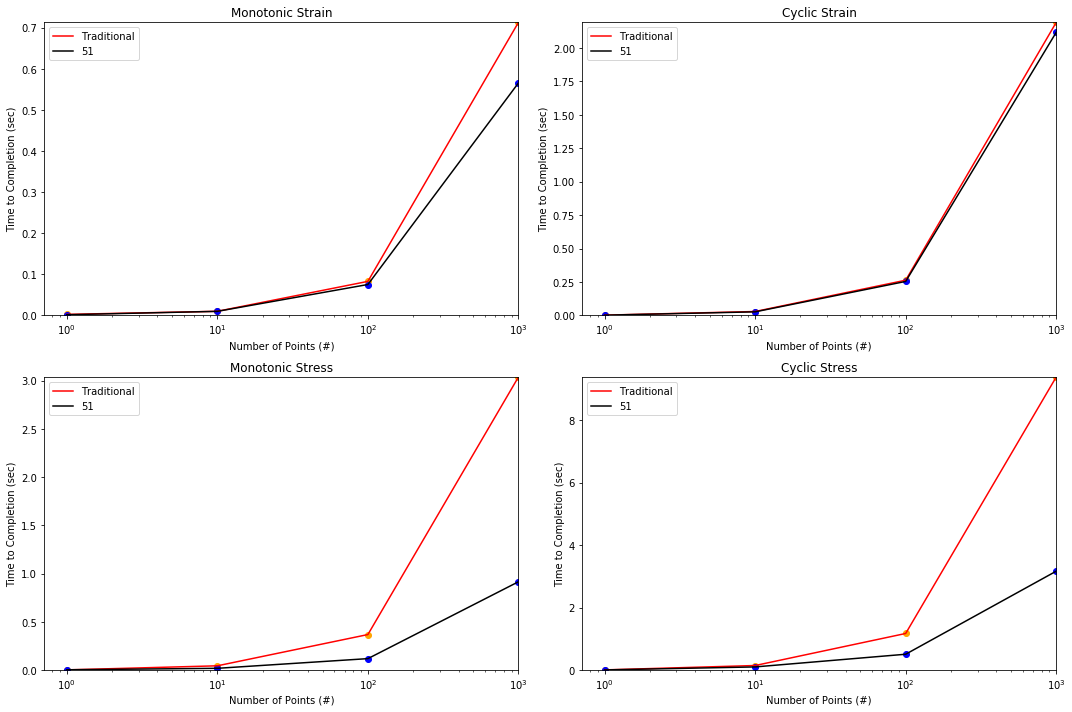

In [152]:
xscale = 'log'
yscale = 'linear'

fig, axes = plt.subplots(2, 2, figsize = (15,10))

ls = ['-','-.','--',':']

axes[0, 0].plot(nList, oldTime[0,:,0], color='red', label='Traditional')
axes[0, 0].scatter(nList, oldTime[0,:,0], color='orange')
axes[0, 1].plot(nList, oldTime[1,:,0], color='red', label='Traditional')
axes[0, 1].scatter(nList, oldTime[1,:,0], color='orange')
axes[1, 0].plot(nList, oldTime[2,:,0], color='red', label='Traditional')
axes[1, 0].scatter(nList, oldTime[2,:,0], color='orange')
axes[1, 1].plot(nList, oldTime[3,:,0], color='red', label='Traditional')
axes[1, 1].scatter(nList, oldTime[3,:,0], color='orange')

for r in range(0,len(rList)):

    axes[0, 0].plot(nList, newTime[0,:,r], color='black', label=str(rList[r]), linestyle=ls[r])
    axes[0, 0].scatter(nList, newTime[0,:,r], color='blue')
    
    axes[0, 1].plot(nList, newTime[1,:,r], color='black', label=str(rList[r]), linestyle=ls[r])
    axes[0, 1].scatter(nList, newTime[1,:,r], color='blue')

    axes[1, 0].plot(nList, newTime[2,:,r], color='black', label=str(rList[r]), linestyle=ls[r])
    axes[1, 0].scatter(nList, newTime[2,:,r], color='blue')

    axes[1, 1].plot(nList, newTime[3,:,r], color='black', label=str(rList[r]), linestyle=ls[r])
    axes[1, 1].scatter(nList, newTime[3,:,r], color='blue')

axes[0, 0].set_title('Monotonic Strain')
axes[0, 0].set_xlabel('Number of Points (#)')
axes[0, 0].set_ylabel('Time to Completion (sec)')

axes[0, 1].set_title('Cyclic Strain')
axes[0, 1].set_xlabel('Number of Points (#)')
axes[0, 1].set_ylabel('Time to Completion (sec)')

axes[1, 0].set_title('Monotonic Stress')
axes[1, 0].set_xlabel('Number of Points (#)')
axes[1, 0].set_ylabel('Time to Completion (sec)')

axes[1, 1].set_title('Cyclic Stress')
axes[1, 1].set_xlabel('Number of Points (#)')
axes[1, 1].set_ylabel('Time to Completion (sec)')

axes[0, 0].set_xscale(xscale)
axes[0, 1].set_xscale(xscale)
axes[1, 0].set_xscale(xscale)
axes[1, 1].set_xscale(xscale)
axes[0, 0].set_yscale(yscale)
axes[0, 1].set_yscale(yscale)
axes[1, 0].set_yscale(yscale)
axes[1, 1].set_yscale(yscale)
axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()
axes[0, 0].set_ylim(0, max(oldTime[0,:,0]))
axes[0, 1].set_ylim(0, max(oldTime[1,:,0]))
axes[1, 0].set_ylim(0, max(oldTime[2,:,0]))
axes[1, 1].set_ylim(0, max(oldTime[3,:,0]))
axes[0, 0].set_xlim(0, max(nList))
axes[0, 1].set_xlim(0, max(nList))
axes[1, 0].set_xlim(0, max(nList))
axes[1, 1].set_xlim(0, max(nList))
#axes[0,0].set_ylim(0,oldTime.max())
#axes[0,1].set_ylim(0,oldTime.max())
#axes[1,0].set_ylim(0,oldTime.max())
#axes[1,1].set_ylim(0,oldTime.max())
    
plt.tight_layout()
plt.show()

---
# Stability and Iterations

In [153]:
load  = 1 # LoadCase
nList = [1, 3, 10, 30, 100, 300, 1000] # nPoints List
rList = [51] # Resolution List
fList = [0.1, 1, 10, 100] # Factor list for loads

In [ ]:
import time

k = 0
oldTime, newTime = np.zeros((len(fList),len(nList),len(rList))), np.zeros((len(fList),len(nList),len(rList)))
oldIterInner, newIterInner = np.zeros((len(fList),len(nList),len(rList))), np.zeros((len(fList),len(nList),len(rList)))
oldIterOuter, newIterOuter = np.zeros((len(fList),len(nList),len(rList))), np.zeros((len(fList),len(nList),len(rList)))
for r in rList:
    res_x = r
    res_y = r
    res_z = int(np.floor(r/2)) + 1
    print('Resolution:', res_y,'x',res_x,'x',res_z)
    
    # Read the solution matrix from disk
    fn = 'kappaMatrix_' + str(res_y) + '_' + str(res_x) + '.txt'
    kappaM = np.loadtxt(fn).reshape((res_y,res_x,res_z)) # Returns 3D array
    
    i = 0
    for f in fList:
        print('Load Factor:', f)
        oldT, newT = [],[]
        oldII, newII = [],[]
        oldIO, newIO = [],[]
        for n in nList:
            # Traditional Driver
            start = time.time()
            old = BSDriver(load)
            
            end = time.time()
            oldT.append(end - start)
            oldII.append(sum(old.Iter_Inner)/len(old.Iter_Inner))
            oldIO.append(sum(old.Iter)/len(old.Iter))
            
            # Precomputed Driver
            start = time.time()
            new = psiBSDriver(load)
            end = time.time()
            newT.append(end - start)
            newII.append(sum(new.Iter_Psi)/len(new.Iter_Psi))
            newIO.append(sum(new.Iter)/len(new.Iter))
            
            #print('Completed: nPoints = ', n)
            
        oldTime[i,:,k] = oldT
        newTime[i,:,k] = newT
        
        oldIterInner[i,:,k] = oldII
        oldIterOuter[i,:,k] = oldIO
        newIterInner[i,:,k] = newII
        newIterOuter[i,:,k] = newIO   
        
        i += 1
        print('')
        
    k += 1
    print('')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

xscale = 'log'
yscale= 'log'
ls = ['-','--','-.',':','-']

for r in range(0, len(rList)):
    for f in range(0,len(fList)):
        factor = fList[f]
        axes[0,0].plot(nList, oldTime[f,:,0], color='red', linestyle = ls[f], label='Traditional: ' + str(factor))
        axes[0,0].scatter(nList, oldTime[f,:,0], color='orange')
        
        axes[1,0].plot(nList, oldIterInner[f,:,0], color='red', linestyle = ls[f], label='Traditional: ' + str(factor))
        axes[1,0].scatter(nList, oldIterInner[f,:,0], color='orange')

        axes[1,1].plot(nList, oldIterOuter[f,:,0], color='red', linestyle = ls[f], label='Traditional: ' + str(factor))
        axes[1,1].scatter(nList, oldIterOuter[f,:,0], color='orange')

for r in range(0, len(rList)):
    for f in range(0,len(fList)):
        factor = fList[f]
        axes[0,0].plot(nList, newTime[f,:,r], color='black', linestyle = ls[f], label='Precomputed: ' + str(factor))
        axes[0,0].scatter(nList, newTime[f,:,r], color='blue')

        axes[1,0].plot(nList, newIterInner[f,:,r], color='black', linestyle = ls[f], label='Precomputed: ' + str(factor))
        axes[1,0].scatter(nList, newIterInner[f,:,r], color='blue')
        
        axes[1,1].plot(nList, newIterOuter[f,:,r], color='black', linestyle = ls[f], label='Precomputed: ' + str(factor))
        axes[1,1].scatter(nList, newIterOuter[f,:,r], color='blue')

        
#axes[1].plot(nList, )

axes[0,0].set_xlabel('Number of Points [#]')
axes[0,0].set_ylabel('Time to Completion [s]')
axes[0,0].set_xscale(xscale)
axes[0,0].set_yscale(yscale)
axes[0,0].legend(loc='best')

axes[1,0].set_title('Radial Map Iterations')
axes[1,0].set_xlabel('Number of Points [#]')
axes[1,0].set_ylabel('Average Iterations [#]')
axes[1,0].set_xscale(xscale)
#axes[1,0].set_yscale(yscale)
#axes[1,0].set_yscale(yscale)
#axes[1,0].legend(loc='best')

axes[1,1].set_title('Driver Iterations')
axes[1,1].set_xlabel('Number of Points [#]')
axes[1,1].set_ylabel('Average Iterations [#]')
axes[1,1].set_xscale(xscale)
#axes[1,1].set_yscale(yscale)
#axes[1,1].legend()

plt.tight_layout
plt.show()

---
# BREAK

In [ ]:
dStress = np.array([[1],[2],[3]])
print('dStress:',dStress.reshape(3,))
print()

dev_dStress = dev(dStress)
vol_dStress = trace(dStress)*np.array([[1/3],[1/3],[1/3]])
print('dev_dStress:',dev_dStress.reshape(3,))
print('vol_dStress:',vol_dStress.reshape(3,))
print('dStress Reassembled:',(vol_dStress + dev_dStress).reshape(3,))

print('Converted:',convert2StressLike(dStress).reshape(3,))

print()
six = np.array([1,0,0,-.45,0,0]).reshape(6,1)
print('six:',six.reshape(6,))
p1, p2, p3 = princVal(six.reshape(6,1), type=0)
prin = np.array([p1,p2,p3]).reshape(3,1)
vol_prin = (trace(prin)*np.array([1/3,1/3,1/3])).reshape(3,1)
dev_prin = dev(prin).reshape(3,1)
print('Principals:',prin.reshape(3,))
print('dev_prin:',dev_prin.reshape(3,))
print('vol_prin:',vol_prin.reshape(3,))
print('prin Reassmebled:', (vol_prin + dev_prin).reshape(3,))

print()
prin = convert2StressLike(prin)
print('prin Converted:', prin.reshape(3,))
vol_prin = (trace(prin)*np.array([1/3,1/3,1/3])).reshape(3,1)
dev_prin = dev(prin).reshape(3,1)
print('Principals:',prin.reshape(3,))
print('dev_prin:',dev_prin.reshape(3,))
print('vol_prin:',vol_prin.reshape(3,))
print('prin Reassmebled:', (vol_prin + dev_prin).reshape(3,))

print('------')
six = np.array([1,0,0,0,0,0]).reshape(6,1)
print('six:',six.reshape(6,))
dev_six = dev(six)
print('dev_six:',dev_six.reshape(6,))
vol_six = six - dev_six
print('vol_six:',vol_six.reshape(6,))

p1, p2, p3 = princVal(six.reshape(6,1), type=0)
prin = np.array([p1,p2,p3]).reshape(3,1)
p1, p2, p3 = princVal(dev_six.reshape(6,1), type=0)
dev_prin = np.array([p1,p2,p3]).reshape(3,1)
con_dev_prin = convert2StressLike(dev_prin)
p1, p2, p3 = princVal(vol_six.reshape(6,1), type=0)
vol_prin = np.array([p1,p2,p3]).reshape(3,1)
print('Principals:',prin.reshape(3,))
print('dev_prin:',dev_prin.reshape(3,))
print('con_dev_prin:',con_dev_prin.reshape(3,))
print('vol_prin:',vol_prin.reshape(3,))
print('prin Reassmebled:', (vol_prin + dev_prin).reshape(3,))
print('prin Reassmebled:', (vol_prin + con_dev_prin).reshape(3,))

print('------')
six = np.array([1,0,0,0,0,0]).reshape(6,1)

In [ ]:
first_six = np.array([six[0],six[1],six[2],0,0,0]).reshape(6,1)
second_six = np.array([0,0,0,six[3],six[4],six[5]]).reshape(6,1)

p1, p2, p3 = princVal(first_six.reshape(6,1), type=0)
first_prin = np.array([p1,p2,p3]).reshape(3,1)
p1, p2, p3 = princVal(second_six.reshape(6,1), type=0)
second_prin = np.array([p1,p2,p3]).reshape(3,1)
print('Reassambled:', (first_prin + second_prin).reshape(3,))

---
# Reformulation of Stress-Driving

# Psi Version

In [ ]:
%matplotlib inline

In [ ]:
loadcase=2
old = BSDriver(loadcase)
new = solvedBSDriver(loadcase)

In [ ]:
#animateDeviatoricSurface(new.time, new.Stress0, new.stress, new.StaticParam.Su)

In [ ]:
# Convert 6x1 stress and strains to 3x1 principal normal form
new_PrinStress = np.zeros((3,new.stress.shape[1]))
new_PrinStrain = np.zeros((3,new.strain.shape[1]))
for i in range(0,new.strain.shape[1]):
    new_PrinStress[:,i] = principal(new.stress[:,i].reshape(6,1)).ravel()
    new_PrinStrain[:,i] = principal(new.strain[:,i].reshape(6,1)).ravel()

In [ ]:
# Raw error
errStress = (np.abs(new.stress) - np.abs(old.stress) )
errStrain = (np.abs(new.strain) - np.abs(old.strain) )

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old.time, old.stress[0])
axes[0, 0].plot(old.time, old.stress[1])
axes[0, 0].plot(old.time, old.stress[2])
axes[0, 0].plot(old.time, old.stress[3])
axes[0, 0].plot(old.time, old.stress[4])
axes[0, 0].plot(old.time, old.stress[5])
axes[0, 0].set_title('Old Stress vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Old Stress [ ]')
axes[0, 0].set_xlim(old.time.min(), old.time.max())
axes[0, 0].set_ylim(old.stress.min(), old.stress.max())

axes[0, 1].plot(old.time, old.strain[0])
axes[0, 1].plot(old.time, old.strain[1])
axes[0, 1].plot(old.time, old.strain[2])
axes[0, 1].plot(old.time, old.strain[3])
axes[0, 1].plot(old.time, old.strain[4])
axes[0, 1].plot(old.time, old.strain[5])
axes[0, 1].set_title('Old Strain vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Old Strain [ ]')
axes[0, 1].set_xlim(old.time.min(), old.time.max())
axes[0, 1].set_ylim(old.strain.min(), old.strain.max())

axes[1, 0].plot(new.time, new.stress[0])
axes[1, 0].plot(new.time, new.stress[1])
axes[1, 0].plot(new.time, new.stress[2])
axes[1, 0].plot(new.time, new.stress[3])
axes[1, 0].plot(new.time, new.stress[4])
axes[1, 0].plot(new.time, new.stress[5])
axes[1, 0].plot(new.time, new.pseudoStress[0])
axes[1, 0].plot(new.time, new.pseudoStress[1])
axes[1, 0].plot(new.time, new.pseudoStress[2])
axes[1, 0].plot(new.time, new.pseudoStress[3])
axes[1, 0].plot(new.time, new.pseudoStress[4])
axes[1, 0].plot(new.time, new.pseudoStress[5])
axes[1, 0].set_title('New Stress vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('New Stress [ ]')
axes[1, 0].set_xlim(new.time.min(), new.time.max())
axes[1, 0].set_ylim(new.stress.min(), new.stress.max())

axes[1, 1].plot(new.time, new.strain[0])
axes[1, 1].plot(new.time, new.strain[1])
axes[1, 1].plot(new.time, new.strain[2])
axes[1, 1].plot(new.time, new.strain[3])
axes[1, 1].plot(new.time, new.strain[4])
axes[1, 1].plot(new.time, new.strain[5])
axes[1, 1].set_title('New Strain vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Iterations [ ]')
axes[1, 1].set_xlim(new.time.min(), new.time.max())
axes[1, 1].set_ylim(new.strain.min(), new.strain.max())
#axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")
#print(Iter_H)
plt.show()

In [ ]:
old_dev_strain, old_vol_strain = np.zeros((6,len(old.time))),np.zeros((6,len(old.time)))
old_dev_stress, old_vol_stress = np.zeros((6,len(new.time))),np.zeros((6,len(old.time)))
old_j2, new_j2 = [], []
for i in range(len(old.time)):
    old_dev_strain[:,i] = dev(old.strain[:,i]).ravel()
    old_vol_strain[:,i] = trace(old.strain[:,i].reshape(6,1))*np.array([[1/3],[1/3],[1/3],[0],[0],[0]]).ravel()
    old_dev_stress[:,i] = dev(old.stress[:,i]).ravel()
    old_vol_stress[:,i] = trace(old.stress[:,i].reshape(6,1))*np.array([[1/3],[1/3],[1/3],[0],[0],[0]]).ravel()
    old_j2.append(innerProduct(old_dev_stress[:,i],old_dev_stress[:,i],1))
    
new_dev_strain, new_vol_strain = np.zeros((6,len(old.time))),np.zeros((6,len(new.time)))
new_dev_stress, new_vol_stress = np.zeros((6,len(new.time))),np.zeros((6,len(new.time)))
for i in range(len(new.time)):
    new_dev_strain[:,i] = dev(new.strain[:,i]).ravel()
    new_vol_strain[:,i] = trace(new.strain[:,i].reshape(6,1))*np.array([[1/3],[1/3],[1/3],[0],[0],[0]]).ravel()
    new_dev_stress[:,i] = dev(new.stress[:,i]).ravel()
    new_vol_stress[:,i] = trace(new.stress[:,i].reshape(6,1))*np.array([[1/3],[1/3],[1/3],[0],[0],[0]]).ravel()
    new_j2.append(innerProduct(new_dev_stress[:,i],new_dev_stress[:,i],1))
    
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old_dev_strain[0], old_dev_stress[0])
axes[0, 0].plot(old_dev_strain[1], old_dev_stress[1])
axes[0, 0].plot(old_dev_strain[2], old_dev_stress[2])
axes[0, 0].plot(old_dev_strain[0], old_dev_stress[3])
axes[0, 0].plot(old_dev_strain[1], old_dev_stress[4])
axes[0, 0].plot(old_dev_strain[2], old_dev_stress[5])
axes[0, 0].set_title('Old Dev Stress vs Old Dev Strain')
axes[0, 0].set_xlabel('Old Dev Strain [ ]')
axes[0, 0].set_ylabel('Old Dev Stress [MPa]')
axes[0, 0].set_xlim(old_dev_strain.min(), old_dev_strain.max())
axes[0, 0].set_ylim(np.nanmin(old_dev_stress), np.nanmax(old_dev_stress))

axes[0, 1].plot(old_vol_strain[0], old_vol_stress[0])
axes[0, 1].plot(old_vol_strain[1], old_vol_stress[1])
axes[0, 1].plot(old_vol_strain[2], old_vol_stress[2])
axes[0, 1].plot(old_vol_strain[0], old_vol_stress[3])
axes[0, 1].plot(old_vol_strain[1], old_vol_stress[4])
axes[0, 1].plot(old_vol_strain[2], old_vol_stress[5])
axes[0, 1].set_title('Old Vol Stress vs Old Vol Strain')
axes[0, 1].set_xlabel('Old Vol Strain [ ]')
axes[0, 1].set_ylabel('Old Vol Stress [MPa]')
axes[0, 1].set_xlim(old_vol_strain.min(), old_vol_strain.max())
axes[0, 1].set_ylim(np.nanmin(old_vol_stress), np.nanmax(old_vol_stress))

axes[1, 0].plot(new_dev_strain[0], new_dev_stress[0])
axes[1, 0].plot(new_dev_strain[1], new_dev_stress[1])
axes[1, 0].plot(new_dev_strain[2], new_dev_stress[2])
axes[1, 0].plot(new_dev_strain[0], new_dev_stress[3])
axes[1, 0].plot(new_dev_strain[1], new_dev_stress[4])
axes[1, 0].plot(new_dev_strain[2], new_dev_stress[5])
axes[1, 0].set_title('New Dev Stress vs New Dev Strain')
axes[1, 0].set_xlabel('New Dev Strain [ ]')
axes[1, 0].set_ylabel('New Dev Stress [MPa]')
axes[1, 0].set_xlim(new_dev_strain.min(), new_dev_strain.max())
axes[1, 0].set_ylim(new_dev_stress.min(), new_dev_stress.max())

axes[1, 1].plot(new_vol_strain[0], new_vol_stress[0])
axes[1, 1].plot(new_vol_strain[1], new_vol_stress[1])
axes[1, 1].plot(new_vol_strain[2], new_vol_stress[2])
axes[1, 1].plot(new_vol_strain[0], new_vol_stress[3])
axes[1, 1].plot(new_vol_strain[1], new_vol_stress[4])
axes[1, 1].plot(new_vol_strain[2], new_vol_stress[5])
axes[1, 1].set_title('New Vol Stress vs New Vol Strain')
axes[1, 1].set_xlabel('New Vol Strain [ ]')
axes[1, 1].set_ylabel('New Vol Stress [MPa]')
axes[1, 1].set_xlim(new_vol_strain.min(), new_vol_strain[2].max())
axes[1, 1].set_ylim(new_vol_stress.min(), new_vol_stress.max())
axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old_dev_strain[0], old_j2)
axes[0, 0].plot(old_dev_strain[1], old_j2)
axes[0, 0].plot(old_dev_strain[2], old_j2)
axes[0, 0].plot(old_dev_strain[3], old_j2)
axes[0, 0].plot(old_dev_strain[4], old_j2)
axes[0, 0].plot(old_dev_strain[5], old_j2)
axes[0, 0].set_title('Old $\sqrt{J_2}$ vs Old Deviatoric Strain')
axes[0, 0].set_xlabel('Old Deviatoric Strain [ ]')
axes[0, 0].set_ylabel('Old $\sqrt{J_2}$ [MPa]')
axes[0, 0].set_xlim(old_dev_strain.min(), old_dev_strain.max())
axes[0, 0].set_ylim(min(old_j2), max(old_j2))

axes[0, 1].plot(new_dev_strain[0], new_j2)
axes[0, 1].plot(new_dev_strain[1], new_j2)
axes[0, 1].plot(new_dev_strain[2], new_j2)
axes[0, 1].plot(new_dev_strain[3], new_j2)
axes[0, 1].plot(new_dev_strain[4], new_j2)
axes[0, 1].plot(new_dev_strain[5], new_j2)
axes[0, 1].set_title('New $\sqrt{J_2}$ vs New Deviatoric Strain')
axes[0, 1].set_xlabel('New Deviatoric Strain [ ]')
axes[0, 1].set_ylabel('New $\sqrt{J_2}$ [MPa]')
axes[0, 1].set_xlim(new_dev_strain.min(), new_dev_strain.max())
axes[0, 1].set_ylim(min(new_j2), max(new_j2))

plt.show()

In [ ]:
# Normalize deviatoric and volumetric stress/strain errors
devErrStrain = np.abs(np.abs(old_dev_strain)-np.abs(new_dev_strain))
volErrStrain = np.abs(np.abs(old_vol_strain)-np.abs(new_vol_strain))
devErrStress = np.abs(np.abs(old_dev_stress)-np.abs(new_dev_stress))
volErrStress = np.abs(np.abs(old_vol_stress)-np.abs(new_vol_stress))

normDevErrStrain = np.zeros((old.strain.shape[0],old.strain.shape[1]))
normVolErrStrain = np.zeros((old.strain.shape[0],old.strain.shape[1]))
normDevErrStress = np.zeros((old.strain.shape[0],old.strain.shape[1]))
normVolErrStress = np.zeros((old.strain.shape[0],old.strain.shape[1]))
for i in range(0, old.stress.shape[1]):
    normDevErrStrain[:,i] = 100*devErrStrain[:,i]/old_dev_strain.max()
    normVolErrStrain[:,i] = 100*volErrStrain[:,i]/old_vol_strain.max()
    normDevErrStress[:,i] = 100*devErrStress[:,i]/old_dev_stress.max()
    normVolErrStress[:,i] = 100*volErrStress[:,i]/old_vol_stress.max()

fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(old.time, normDevErrStress[0], label='$\sigma_{1}\'$')
axes[0, 0].plot(old.time, normDevErrStress[1], label='$\sigma_{2}\'$')
axes[0, 0].plot(old.time, normDevErrStress[2], label='$\sigma_{3}\'$')
axes[0, 0].plot(old.time, normDevErrStress[3], label='$\sigma_{1}\'$')
axes[0, 0].plot(old.time, normDevErrStress[4], label='$\sigma_{2}\'$')
axes[0, 0].plot(old.time, normDevErrStress[5], label='$\sigma_{3}\'$')
axes[0, 0].set_title('Normalized Deviatoric Stress Difference vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Normalized Deviatoric Stress Difference [%]')
#axes[0, 0].set_xlim(old.time.min(), old.time.max())
#axes[0, 0].set_ylim(np.nanmin(normDevErrStress), np.nanmax(normDevErrStress))
axes[0, 0].legend()

axes[0, 1].plot(old.time, normVolErrStress[0], label='$tr(\sigma)$')
axes[0, 1].plot(old.time, normVolErrStress[1])
axes[0, 1].plot(old.time, normVolErrStress[2])
axes[0, 1].plot(old.time, normVolErrStress[3], label='$tr(\sigma)$')
axes[0, 1].plot(old.time, normVolErrStress[4])
axes[0, 1].plot(old.time, normVolErrStress[5])
axes[0, 1].set_title('Normalized Volumetric Stress Difference vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Normalized Volumetric Stress Difference [%]')
#axes[0, 1].set_xlim(old.time.min(), old.time.max())
#axes[0, 1].set_ylim(normVolErrStress.min(), normVolErrStress.max())
axes[0, 1].legend()

axes[1, 0].plot(old.time, normDevErrStrain[0], label='$\epsilon_{1}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[1], label='$\epsilon_{2}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[2], label='$\epsilon_{3}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[3], label='$\epsilon_{1}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[4], label='$\epsilon_{2}\'$')
axes[1, 0].plot(old.time, normDevErrStrain[5], label='$\epsilon_{3}\'$')
axes[1, 0].set_title('Normalized Deviatoric Strain Difference vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Normalized Deviatoric Strain Difference [%]')
#axes[1, 0].set_xlim(old.time.min(), old.time.max())
#axes[1, 0].set_ylim(np.nan_to_num(normDevErrStrain.min()), np.nan_to_num(normDevErrStrain.max()))
axes[1, 0].legend()

axes[1, 1].plot(old.time, normVolErrStrain[0], label='$tr(\epsilon)$')
axes[1, 1].plot(old.time, normVolErrStrain[1])
axes[1, 1].plot(old.time, normVolErrStrain[2])
axes[1, 1].plot(old.time, normVolErrStrain[3], label='$tr(\epsilon)$')
axes[1, 1].plot(old.time, normVolErrStrain[4])
axes[1, 1].plot(old.time, normVolErrStrain[5])
axes[1, 1].set_title('Normalized Volumetric Strain Difference vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Normalized Volumetric Strain Difference [%]')
#axes[1, 1].set_xlim(old.time.min(), old.time.max())
#axes[1, 1].set_ylim(np.nan_to_num(normVolErrStrain.min()), np.nan_to_num(normVolErrStrain.max()))
axes[1, 1].legend()

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))

axes[0, 0].plot(new.time, new.kappa, color='black')
axes[0, 0].set_title('$\kappa$ vs Time')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('$\kappa$ [ ]')
axes[0, 0].set_xlim(new.time.min(), new.time.max())
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(min(new.kappa), max(new.kappa))

axes[0, 1].plot(new.time, new.H, color='black')
axes[0, 1].set_title('$H\'$ vs Time')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('$H\'$ [ ]')
axes[0, 1].set_xlim(new.time.min(), new.time.max())
axes[0, 1].set_yscale('log')
axes[0, 1].set_ylim(min(new.H), max(new.H))

axes[1, 0].plot(new.time, new.psi, color='black')
axes[1, 0].set_title('$\psi$ vs Time')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('$\psi$ [ ]')
axes[1, 0].set_xlim(new.time.min(), new.time.max())
axes[1, 0].set_ylim(min(new.psi), 2*new.StaticParam.G)

#axes[1, 1].set_yscale('log')
axes[1, 1].plot(new.time, new.Iter_H, label = '$H\'$')
axes[1, 1].plot(new.time, new.Iter_Psi, label = '$\psi$')
axes[1, 1].set_title('Iterations vs Time')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Iterations [ ]')
axes[1, 1].set_xlim(new.time.min(), new.time.max())
axes[1, 1].set_ylim(0, max(max(new.Iter_H),max(new.Iter_Psi)))
axes[1, 1].legend(bbox_to_anchor=(0.95,0.85), loc="center right")

plt.show()

---
# Sandbox

For testing, ignore

In [ ]:
rrN = [1,2,3,4,5]
rrS = [10,11,12]
rr=[]
end = min(len(rrS),len(rrN))
for i in range(min(len(rrS),len(rrN))):
    rr.append(rrS[i])
    rr.append(rrN[i])
if len(rrN) > end:
    for e in range(end,len(rrN)):
        rr.append(rrN[e])
if len(rrS) > end:
    for e in range(end,len(rrS)):
        rr.append(rrS[e])
    
print(rr)

In [ ]:
stress = np.array([1,1,1,.05,0,0]).reshape(6,1)
v1, v2, v3 = princVec(stress,0)
p1, p2, p3 = princVal(stress,0)
print(p1,p2,p3)
eVec = np.array([v1,v2,v3]).reshape(3,3).T
print(eVec)




In [ ]:
def compareEig(a,b):
    print('a:',a)
    print('b:',b)
    print('')
    v1A, v2A, v3A = princVec(a,0)
    p1A, p2A, p3A = princVal(a,0)
    eValA = np.array([p1A,p2A,p3A])
    eVecA = np.array([v1A,v2A,v3A]).reshape(3,3).T
    print('A Eigenvalues')
    print(p1A,p2A,p3A)
    print('A Eigenvectors')
    print(eVecA)

    print('')
    v1B, v2B, v3B = princVec(b,0)
    p1B, p2B, p3B = princVal(b,0)
    eValB = np.array([p1B,p2B,p3B])
    eVecB = np.array([v1B,v2B,v3B]).reshape(3,3).T
    print('B Eigenvalues')
    print(p1B,p2B,p3B)
    print('B Eigenvectors')
    print(eVecB)

    print('')
    signA = np.sign(eVecA)
    signB = np.sign(eVecB)
    print('signA')
    print(signA)
    print('signB')
    print(signB)
    print('Signs from A to B')
    print(np.sign(eVecA-eVecB))
    
    print(angleNormal(eVecA[:,0],eVecA[:,2])*180/np.pi)
    
    return eValA, eValB, eVecA, eVecB

In [ ]:
a = np.array([.1,0,0,0,0,0])
b = convert2StressLike(a)
a = dev(a.reshape(1,6))
b = dev(b.reshape(1,6))

eValA, eValB, eVecA, eVecB = compareEig(a,b)

In [ ]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.animation 
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


for i in range(0,3):
    main = np.array([0,1])
    fill = np.array([0,0])
    p = Arrow3D(main,fill,fill,
                mutation_scale=20, lw=3, arrowstyle="-|>", color="black",alpha=0.5, linestyle=':',label='\sigma_3')
    q = Arrow3D(fill,main,fill,
                mutation_scale=20, lw=3, arrowstyle="-|>", color="black",alpha=0.5, linestyle=':',label='\sigma_2')
    r = Arrow3D(fill,fill,main,
                mutation_scale=20, lw=3, arrowstyle="-|>", color="black",alpha=0.5, linestyle=':',label='\sigma_1')
    ax.add_artist(p)
    ax.add_artist(q)
    ax.add_artist(r)   

useA = True
if useA == True:
    for i in range(0,3):
        x = np.array([0,eVecA[2,i]])
        y = np.array([0,eVecA[1,i]])
        z = np.array([0,eVecA[0,i]])
        a = Arrow3D(x,y,z,mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color="b",alpha=0.5)
        ax.add_artist(a)
    
    dev_eVecA = np.zeros(eVecA.shape)
    for i in range(0,3):
        dev_eVecA[:,i] = dev(eVecA[:,i].reshape(3,1)).reshape(3,)
        x = np.array([0,dev_eVecA[2,i]])
        y = np.array([0,dev_eVecA[1,i]])
        z = np.array([0,dev_eVecA[0,i]])
        dev_a = Arrow3D(x,y,z,mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color="b",alpha=0.5, linestyle=':')
        ax.add_artist(dev_a)
        ax.scatter(eValA[2],eValA[1],eValA[0], color='cyan',alpha=0.5)
        dev_eValA = eValA[0]*eVecA[0,:] + eValA[1]*eVecA[1,:] + eValA[2]*eVecA[2,:]
        ax.scatter(dev_eValA[2],dev_eValA[1],dev_eValA[0], color='darkblue')
        
        
        
useB = True
if useB == True:
    for i in range(0,3): 
        x = np.array([0,eVecB[2,i]])
        y = np.array([0,eVecB[1,i]])
        z = np.array([0,eVecB[0,i]])
        b = Arrow3D(x,y,z,mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color="r",alpha=0.5)

        ax.add_artist(b)
        

        
    dev_eVecB = np.zeros(eVecB.shape)
    for i in range(0,3):
        dev_eVecB[:,i] = dev(eVecB[:,i].reshape(3,1)).reshape(3,)
        x = np.array([0,dev_eVecB[2,i]])
        y = np.array([0,dev_eVecB[1,i]])
        z = np.array([0,dev_eVecB[0,i]])
        dev_b = Arrow3D(x,y,z,mutation_scale=20, 
                    lw=3, arrowstyle="-|>", color="r",alpha=0.5, linestyle=':')

        ax.add_artist(dev_b)
        
        ax.scatter(eValB[2],eValB[1],eValB[0], color='pink',alpha=0.5)
        dev_eValB = eValB[0]*eVecB[0,:] + eValB[1]*eVecB[1,:] + eValB[2]*eVecB[2,:]
        ax.scatter(dev_eValB[2],dev_eValB[1],dev_eValB[0], color='darkred')
        
zUnit = dev(np.array([0,0,np.sqrt(2/3)]).reshape(3,1))
xyUnit = dev(np.array([-(1/2),(1/2),0]).reshape(3,1))

Oct = np.array([(zUnit + xyUnit).reshape(3,), 
               (-1*zUnit + xyUnit).reshape(3,), 
               (-1*zUnit - 1*xyUnit).reshape(3,), 
               (1*zUnit - 1*xyUnit).reshape(3,)]).T.T


import mpl_toolkits.mplot3d as a3
Oct = a3.art3d.Poly3DCollection([Oct],alpha=0.25)
Oct.set_color('green')
Oct.set_edgecolor('k')
ax.add_collection3d(Oct)


ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

plt.title('Eigenvectors')
plt.legend()
plt.draw()
plt.show()